In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import cv2, os, math, time, sys
from datetime import timedelta
from sklearn.utils import shuffle
sys.path.append('../../original_images')
from gen_data_batch import generate_batch
from scipy import *

../../original_images/psvrt.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/as186233/anaconda2/envs/py36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/as186233/anaconda2/envs/py36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/as186233/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/as186233/anaconda2/envs/py36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/as186233/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/kernelapp.py

### Configuration

In [ ]:
###Configuration
"""
Data Configurations/Paths
"""
img_dir_patch="./SD/predicted_patches"
img_dir_orig = "../../original_images/SD"

model20m = 'SD/model20m.ckpt'
# img_type = "original"
img_type = "patch"

##
# Convolutional Layer 1.
filter_size1 = 4          # Convolution filters are 4 x 4 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 2          # Convolution filters are 2 x 2 pixels.
num_filters2 = 32         # There are 32 of these filters.

# Convolutional Layer 3.
filter_size3 = 2          # Convolution filters are 2 x 2 pixels.
num_filters3 = 64         # There are 64 of these filters.

# Convolutional Layer 4.
filter_size4 = 2          # Convolution filters are 2 x 2 pixels.
num_filters4 = 128         # There are 128 of these filters.

# Fully-connected layer.
fc_size = 256             # Number of neurons in fully-connected layer.

### Load Data

In [ ]:
def change_label_dimensions(labels):
    label_temp = np.zeros((len(labels), 2))
    
    for idx in range(0, len(labels)):
        if labels[idx] == 1:
            label_temp[idx][1] = 1
        else:
            label_temp[idx][0] = 1
    
    return label_temp

def load_data(img_dir, img_type="patch"):
        list_of_imgs = []
        list_same_diff = []
        for img_no in os.listdir(img_dir):
            img_no_path = os.path.join(img_dir, img_no)
            for img_label in os.listdir(img_no_path):
                    
                list_same_diff.append(int(img_label))
                img_lbl_path = os.path.join(img_no_path, img_label)
#                 print(img_lbl_path)
                if img_type == "original":
                    img_lbl_path = img_lbl_path + "/img/"
                    
                if img_type == "patch":
                    for img in os.listdir(img_lbl_path):
#                         if img == "labels":
                        img_path = os.path.join(img_lbl_path, img)
#                             img_path = img_path + "/merged_patch.png"
                        list_of_imgs.append(img_path)
                else:    
                    for img in os.listdir(img_lbl_path):
                        img_path = os.path.join(img_lbl_path, img)
                        list_of_imgs.append(img_path)
#         print(list_of_imgs)
        data_imgs = np.array(list_of_imgs)
        data_same_diff = np.array(list_same_diff)

        return data_imgs, data_same_diff

# def load_data(img_dir):
#         list_of_imgs = []
#         list_same_diff = []
#         for img_no in os.listdir(img_dir):
#             if img_no == ".DS_Store":
#                 continue

#             img_no_path = os.path.join(img_dir, img_no)
#             for img_label in os.listdir(img_no_path):
#                 if img_label == ".DS_Store":
#                     continue
                    
#                 list_same_diff.append(int(img_label))
#                 img_lbl_path = os.path.join(img_no_path, img_label)
#                 for img in os.listdir(img_lbl_path):
#                     img_path = os.path.join(img_lbl_path, img)
#                     list_of_imgs.append(img_path)

#         data_imgs = np.array(list_of_imgs)
#         data_same_diff = np.array(list_same_diff)

#         return data_imgs, data_same_diff

    
def get_batch_images(data, same_diff, type_img = "patch"):
        list_of_imgs = []
        list_of_same_diff = []
        for img, img_type in zip(data, same_diff):
            orig_img = cv2.imread(img)
            #only first image as a label
            if orig_img is None:
                    print ("Unable to read image{}".format(img))
                    continue
            
            if type_img == "original":
                flattened_img = orig_img.flatten()
                list_of_imgs.append(np.asarray(flattened_img, dtype=np.float32))
                
                if img_type == 1: #0 is same and 1 is different
                    list_of_same_diff.append([0,1])
                else:
                    list_of_same_diff.append([1,0])
            else:            
                if orig_img.shape == (4, 2, 3):
                    flattened_img = orig_img.flatten()
                    list_of_imgs.append(np.asarray(flattened_img, dtype=np.float32))

                    if img_type == 1: #0 is same and 1 is different
                        list_of_same_diff.append([0,1])
                    else:
                        list_of_same_diff.append([1,0])
        
        data_imgs = np.array(list_of_imgs)
        data_img_type = np.array(list_of_same_diff)
        
        return data_imgs, data_img_type

### Next Batch Own Implementation

In [ ]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

### Data Dimensions

In [ ]:
# Number of colour channels for the images: 3 channel for RGB.
num_channels = 3

# Tuple with height and width of images used to reshape arrays.
img_shape = (60, 60, num_channels)

# Number of classes, one class for same and one for different image
num_classes = 2

### Image Plot Functions

In [ ]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(cv2.imread(images[i]).flatten().reshape((8,4, 3)), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
    
def generate_size_graph(fig_no, training_size, accuracy, loss, patch_only,patch_conv, start_size, end_size):
    plt.figure(fig_no,figsize=(7,5))
    plt.plot(training_size,accuracy)
    plt.plot(training_size,loss)
    plt.plot(training_size, patch_only)
    plt.plot(training_size, patch_conv)
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.title('Training Size vs Accuracy')
    plt.grid(True)
    plt.legend(['SD Original Accuracy','SR Accuracy', 'SD Patch Accuracy', 'SD Patch Conv'])
    plt.style.use(['classic'])
    plt.show()
    plt.savefig(path + '/batch_graphs/' +  str(start_size) + '_' + str(end_size) + '.jpg') 
        
def generate_graph(fig_no, epochs, train, val, label, train_title, val_title, train_size):
    plt.figure(fig_no,figsize=(7,5))
    plt.plot(epochs,train)
    plt.plot(epochs,val)
    plt.xlabel('num of Epochs')
    plt.ylabel(label)
    plt.title(train_title + ' vs ' + val_title + '( Samples:' + str(train_size) + ')')
    plt.grid(True)
    plt.legend(['Patch','SD'])
    plt.style.use(['classic'])
    plt.show()
#     plt.savefig(results_path + '/batch_graphs/' +  label + '_' + str(train_size) + '.jpg')     

### Helper Functions for TF Graph Initialization

In [ ]:
def new_weights(shape):
    initializer = tf.contrib.layers.xavier_initializer()
    return tf.Variable(initializer(shape))
#     return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_bias(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

### Helper Functions for Network

In [ ]:
def new_conv_layer(input,
                   num_input_channels,
                   filter_size,
                   num_filters,
                   use_pooling=True):

    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape)
    biases = new_bias(length=num_filters)
    
    layer = tf.nn.conv2d(input=input,
                     filter=weights,
                     strides=[1, 1, 1, 1],
                     padding='SAME')
    layer += biases

    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 3, 3, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
    layer = tf.nn.relu(layer)

    return layer, weights

def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    return layer_flat, num_features

def new_fc_layer(input,
                num_inputs,
                num_outputs,
                use_relu=True):

    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_bias(length=num_outputs)
    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
    
    return layer

In [ ]:
x = tf.placeholder(tf.float32, shape=[None, img_shape[0]*img_shape[1]*num_channels], name='x')
x_image = tf.reshape(x, [-1, img_shape[0], img_shape[1], num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)
x_image.shape, y_true

### Convolution Layers

In [ ]:
layer1_conv1, weights_conv1 = new_conv_layer(input=x_image,
                                            num_input_channels=num_channels,
                                            filter_size=filter_size1,
                                            num_filters=num_filters1,
                                            use_pooling=True)

layer2_conv2, weights_conv2 =  new_conv_layer(input=layer1_conv1,
                                           num_input_channels=num_filters1,
                                           filter_size=filter_size2,
                                           num_filters=num_filters2,
                                           use_pooling=True)

layer3_conv3, weights_conv3 =  new_conv_layer(input=layer2_conv2,
                                           num_input_channels=num_filters2,
                                           filter_size=filter_size3,
                                           num_filters=num_filters3,
                                           use_pooling=True)

layer4_conv4, weights_conv4 =  new_conv_layer(input=layer3_conv3,
                                           num_input_channels=num_filters3,
                                           filter_size=filter_size4,
                                           num_filters=num_filters4,
                                           use_pooling=True)

In [ ]:
layer_flat, num_features = flatten_layer(layer4_conv4)

### Fully Connected Layers

In [ ]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)


layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=fc_size,
                         use_relu=False)

layer_fc3 = new_fc_layer(input=layer_fc2,
                         num_inputs=fc_size,
                         num_outputs=fc_size,
                         use_relu=False)

layer_fc4 = new_fc_layer(input=layer_fc3,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

drop_out = tf.nn.dropout(layer_fc4, 0.5)

##Normalize the numbers(apply softmax!)

y_pred = tf.nn.softmax(drop_out)
y_pred_cls = tf.argmax(y_pred, axis=1)

### Cost Function

In [ ]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=drop_out,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)

### Optimization Method

In [ ]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

## some more performance measures
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Run Tensorflow on Defined Graph

In [ ]:
def optimize(num_epochs, save_model=True,save_name= "base_model",restore_model=False,restore_name=None):
    total_iterations = 0
    done_train_imgs = 0
    start_time = time.time()
    start_batch=0
    end_batch = train_batch_size
    plot_accuracy=[]
    plot_accuracy_epoch=[]
    plot_training_size=[]
    plot_training_size_epoch=[]
    saver = tf.train.Saver()
    sum_accuracy = 0.0
    n = 1
    
        #to save the model
    for i in range(0, num_epochs):   
        start_batch=0
        end_batch = train_batch_size
        
        print("Epoch:", i + 1)
        
        if restore_model==True:
            if restore_name==None:
                print("No model file specified")
                return
            else:
                saver.restore(session,restore_name)
        
        sum_accuracy = 0.0
        n = 1
        while end_batch < total_imgs:
#             train = train_data[start_batch:end_batch]
#             labels = train_labels[start_batch:end_batch]
#             train, labels = get_batch_images(train, labels, img_type)
            train, labels = generate_batch(train_batch_size, img_shape)
            if not len(train) and not len(labels):
                print("All images have been processed.")
                break;

            x_batch, y_true_batch = next_batch(len(train), train, labels)
            feed_dict_train = {x: x_batch,
                       y_true: y_true_batch}
            
            session.run(optimizer, feed_dict=feed_dict_train)
    
            acc,co = session.run([accuracy, cost], feed_dict=feed_dict_train)
            sum_accuracy += acc
            n+=1
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}, Loss: {2:>.4f}"
            print(msg.format(end_batch + 1, acc, co))
            if end_batch % 100:
                plot_accuracy.append(acc)
                plot_training_size.append(end_batch + 1)

            start_batch += train_batch_size
            end_batch += train_batch_size
    
        if save_model==True:
            if save_name==None:
                print("No model specified, model not being saved")
                return
            else:
                save_path = saver.save(session, save_name)
                restore_model = True
                print("Model saved in file: %s" % save_name)
        plot_accuracy_epoch.append(sum_accuracy/n)
        plot_training_size_epoch.append(i + 1)
    
    end_time = time.time()
    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))  
    print(plot_accuracy)
    print(plot_training_size)
    print(plot_accuracy_epoch)
    print(plot_training_size_epoch)

### Performance/Optimization

In [ ]:
total_imgs = 1024
train_batch_size = 50

save_model = True
save_name = model20m
restore_model=False
restore_name=model20m

session = tf.Session()
session.run(tf.global_variables_initializer())
optimize(num_epochs=1, save_model=True,save_name=model20m,restore_model=False,restore_name=model20m)

In [ ]:
tensor_names = [t.name for op in tf.get_default_graph().get_operations() for t in op.values()]
tensor_names

In [ ]:
accuracy_sr_plot = [0.5, 0.75, 0.78125, 0.8125, 0.8125, 0.8125, 0.8125, 0.828125, 0.875, 0.90625, 0.78125, 0.90625, 0.78125, 0.921875, 0.828125, 0.921875]
accuracy_sd_plot = [0.421875, 0.484375, 0.484375, 0.453125, 0.578125, 0.515625, 0.5625, 0.5625, 0.5, 0.5625, 0.671875, 0.59375, 0.421875, 0.5625, 0.484375, 0.515625]
accuracy_sd_patchonly_plot = [0.578125, 0.890625, 0.8125, 0.890625, 0.890625, 0.8125, 0.796875, 0.9375, 0.90625, 0.890625, 0.90625, 0.84375, 0.859375, 0.828125, 0.9375, 0.890625]
accuracy_sd_conv_plot = [0.609375, 0.671875, 0.828125, 0.84375, 0.78125, 0.8125, 0.859375, 0.828125, 0.84375, 0.890625, 0.953125, 0.90625, 0.921875, 0.84375, 0.921875, 0.859375]
training_size_sd_plot = [64, 64064, 128064, 192064, 256064, 320064, 384064, 448064, 512064, 576064, 640064, 704064, 768064, 832064, 896064, 960064]

In [ ]:
# fig_no, training_size, accuracy, loss, start_size, end_size

generate_size_graph(1, training_size_sd_plot, accuracy_sd_plot, accuracy_sr_plot,accuracy_sd_patchonly_plot,accuracy_sd_conv_plot,  64, 960064)

### Plot Error

In [ ]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])
    
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Print Accuracy

In [ ]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [ ]:
train_data[:64]

In [ ]:
x_batch, y_true_batch = data.test.next_batch(64)
x_batch

In [ ]:
type(data.train.labels)

In [ ]:
[0.84375, 0.8125, 0.78125, 0.859375, 0.796875, 0.84375, 0.796875, 0.71875, 0.6875, 0.8125, 0.890625, 0.8125, 0.84375, 0.796875, 0.75, 0.890625, 0.78125, 0.859375, 0.78125, 0.78125, 0.765625, 0.828125, 0.75, 0.796875, 0.796875, 0.734375, 0.84375, 0.828125, 0.84375, 0.6875, 0.796875, 0.84375, 0.796875, 0.84375, 0.828125, 0.859375, 0.828125, 0.84375, 0.78125, 0.90625, 0.84375, 0.875, 0.65625, 0.828125, 0.828125, 0.734375, 0.84375, 0.796875, 0.875, 0.828125, 0.71875, 0.875, 0.75, 0.875, 0.828125, 0.765625, 0.84375, 0.875, 0.734375, 0.75, 0.84375, 0.84375, 0.8125, 0.796875, 0.8125, 0.828125, 0.8125, 0.8125, 0.8125, 0.859375, 0.890625, 0.859375, 0.859375, 0.75, 0.75, 0.8125, 0.78125, 0.828125, 0.84375, 0.78125, 0.78125, 0.84375, 0.8125, 0.859375, 0.796875, 0.859375, 0.875, 0.828125, 0.75, 0.84375, 0.796875, 0.90625, 0.75, 0.859375, 0.828125, 0.828125, 0.859375, 0.90625, 0.859375, 0.734375, 0.859375, 0.90625, 0.84375, 0.859375, 0.71875, 0.765625, 0.796875, 0.890625, 0.75, 0.828125, 0.828125, 0.875, 0.796875, 0.765625, 0.890625, 0.8125, 0.828125, 0.78125, 0.890625, 0.734375, 0.796875, 0.90625, 0.84375, 0.75, 0.859375, 0.8125, 0.828125, 0.890625, 0.796875, 0.859375, 0.765625, 0.84375, 0.796875, 0.78125, 0.8125, 0.734375, 0.875, 0.8125, 0.78125, 0.8125, 0.71875, 0.78125, 0.859375, 0.78125, 0.890625, 0.90625, 0.8125, 0.78125, 0.828125, 0.8125, 0.78125, 0.78125, 0.796875, 0.734375, 0.859375, 0.765625, 0.8125, 0.828125, 0.828125, 0.84375, 0.84375, 0.859375, 0.78125, 0.765625, 0.8125, 0.8125, 0.765625, 0.875, 0.8125, 0.828125, 0.875, 0.875, 0.765625, 0.796875, 0.890625, 0.828125, 0.859375, 0.734375, 0.8125, 0.765625, 0.859375, 0.78125, 0.875, 0.78125, 0.890625, 0.765625, 0.8125, 0.875, 0.84375, 0.890625, 0.796875, 0.8125, 0.828125, 0.765625, 0.8125, 0.890625, 0.859375, 0.78125, 0.828125, 0.8125, 0.96875, 0.875, 0.78125, 0.78125, 0.875, 0.703125, 0.796875, 0.875, 0.78125, 0.828125, 0.84375, 0.796875, 0.84375, 0.796875, 0.84375, 0.921875, 0.828125, 0.828125, 0.859375, 0.796875, 0.78125, 0.78125, 0.8125, 0.78125, 0.828125, 0.890625, 0.875, 0.75, 0.796875, 0.90625, 0.859375, 0.859375, 0.875, 0.8125, 0.78125, 0.90625, 0.75, 0.828125, 0.875, 0.765625, 0.828125, 0.859375, 0.859375, 0.828125, 0.78125, 0.8125, 0.8125, 0.859375, 0.84375, 0.875, 0.84375, 0.859375, 0.875, 0.828125, 0.84375, 0.796875, 0.875, 0.84375, 0.796875, 0.78125, 0.859375, 0.859375, 0.8125, 0.859375, 0.796875, 0.703125, 0.828125, 0.875, 0.859375, 0.796875, 0.828125, 0.875, 0.84375, 0.890625, 0.859375, 0.796875, 0.8125, 0.875, 0.796875, 0.859375, 0.875, 0.828125, 0.703125, 0.78125, 0.703125, 0.84375, 0.796875, 0.875, 0.890625, 0.890625, 0.8125, 0.84375, 0.78125, 0.84375, 0.84375, 0.875, 0.8125, 0.859375, 0.796875, 0.828125, 0.84375, 0.859375, 0.859375, 0.8125, 0.828125, 0.796875, 0.8125, 0.8125, 0.84375, 0.84375, 0.8125, 0.828125, 0.828125, 0.8125, 0.890625, 0.78125, 0.796875, 0.796875, 0.828125, 0.84375, 0.90625, 0.859375, 0.84375, 0.875, 0.75, 0.84375, 0.890625, 0.765625, 0.875, 0.84375, 0.84375, 0.84375, 0.859375, 0.921875, 0.75, 0.859375, 0.828125, 0.75, 0.875, 0.765625, 0.859375, 0.875, 0.78125, 0.90625, 0.75, 0.71875, 0.75, 0.859375, 0.78125, 0.78125, 0.84375, 0.875, 0.859375, 0.765625, 0.84375, 0.78125, 0.890625, 0.78125, 0.703125, 0.796875, 0.78125, 0.78125, 0.875, 0.875, 0.859375, 0.8125, 0.859375, 0.8125, 0.859375, 0.765625, 0.765625, 0.78125, 0.8125, 0.84375, 0.859375, 0.8125, 0.859375, 0.78125, 0.78125, 0.75, 0.84375, 0.765625, 0.859375, 0.78125, 0.78125, 0.8125, 0.703125, 0.828125, 0.75, 0.90625, 0.8125, 0.828125, 0.84375, 0.859375, 0.75, 0.796875, 0.890625, 0.890625, 0.78125, 0.8125, 0.71875, 0.796875, 0.859375, 0.84375, 0.859375, 0.8125, 0.828125, 0.84375, 0.8125, 0.84375, 0.828125, 0.78125, 0.8125, 0.828125, 0.8125, 0.828125, 0.765625, 0.765625, 0.765625, 0.703125, 0.828125, 0.734375, 0.875, 0.875, 0.84375, 0.8125, 0.84375, 0.734375, 0.84375, 0.890625, 0.859375, 0.8125, 0.84375, 0.859375, 0.828125, 0.765625, 0.890625, 0.84375, 0.796875, 0.890625, 0.8125, 0.734375, 0.703125, 0.921875, 0.859375, 0.90625, 0.78125, 0.84375, 0.71875, 0.828125, 0.828125, 0.84375, 0.875, 0.828125, 0.8125, 0.78125, 0.828125, 0.890625, 0.921875, 0.828125, 0.828125, 0.84375, 0.84375, 0.828125, 0.828125, 0.84375, 0.859375, 0.859375, 0.84375, 0.765625, 0.78125, 0.8125, 0.828125, 0.796875, 0.84375, 0.84375, 0.75, 0.765625, 0.890625, 0.765625, 0.859375, 0.875, 0.875, 0.734375, 0.859375, 0.796875, 0.859375, 0.859375, 0.828125, 0.84375, 0.8125, 0.71875, 0.890625, 0.828125, 0.765625, 0.84375, 0.78125, 0.90625, 0.71875, 0.828125, 0.84375, 0.796875, 0.828125, 0.875, 0.875, 0.875, 0.828125, 0.78125, 0.859375, 0.84375, 0.796875, 0.75, 0.890625, 0.8125, 0.875, 0.8125, 0.8125]
[65, 129, 193, 257, 321, 385, 449, 513, 577, 641, 705, 769, 833, 897, 961, 1025, 1089, 1153, 1217, 1281, 1345, 1409, 1473, 1537, 1601, 1665, 1729, 1793, 1857, 1921, 1985, 2049, 2113, 2177, 2241, 2305, 2369, 2433, 2497, 2561, 2625, 2689, 2753, 2817, 2881, 2945, 3009, 3073, 3137, 3201, 3265, 3329, 3393, 3457, 3521, 3585, 3649, 3713, 3777, 3841, 3905, 3969, 4033, 4097, 4161, 4225, 4289, 4353, 4417, 4481, 4545, 4609, 4673, 4737, 4801, 4865, 4929, 4993, 5057, 5121, 5185, 5249, 5313, 5377, 5441, 5505, 5569, 5633, 5697, 5761, 5825, 5889, 5953, 6017, 6081, 6145, 6209, 6273, 6337, 6401, 6465, 6529, 6593, 6657, 6721, 6785, 6849, 6913, 6977, 7041, 7105, 7169, 7233, 7297, 7361, 7425, 7489, 7553, 7617, 7681, 7745, 7809, 7873, 7937, 8001, 8065, 8129, 8193, 8257, 8321, 8385, 8449, 8513, 8577, 8641, 8705, 8769, 8833, 8897, 8961, 9025, 9089, 9153, 9217, 9281, 9345, 9409, 9473, 9537, 9601, 9665, 9729, 9793, 9857, 9921, 9985, 10049, 10113, 10177, 10241, 10305, 10369, 10433, 10497, 10561, 10625, 10689, 10753, 10817, 10881, 10945, 11009, 11073, 11137, 11201, 11265, 11329, 11393, 11457, 11521, 11585, 11649, 11713, 11777, 11841, 11905, 11969, 12033, 12097, 12161, 12225, 12289, 12353, 12417, 12481, 12545, 12609, 12673, 12737, 12801, 12865, 12929, 12993, 13057, 13121, 13185, 13249, 13313, 13377, 13441, 13505, 13569, 13633, 13697, 13761, 13825, 13889, 13953, 14017, 14081, 14145, 14209, 14273, 14337, 14401, 14465, 14529, 14593, 14657, 14721, 14785, 14849, 14913, 14977, 15041, 15105, 15169, 15233, 15297, 15361, 15425, 15489, 15553, 15617, 15681, 15745, 15809, 15873, 15937, 16001, 16065, 16129, 16193, 16257, 16321, 16385, 16449, 16513, 16577, 16641, 16705, 16769, 16833, 16897, 16961, 17025, 17089, 17153, 17217, 17281, 17345, 17409, 17473, 17537, 17601, 17665, 17729, 17793, 17857, 17921, 17985, 18049, 18113, 18177, 18241, 18305, 18369, 18433, 18497, 18561, 18625, 18689, 18753, 18817, 18881, 18945, 19009, 19073, 19137, 19201, 19265, 19329, 19393, 19457, 19521, 19585, 19649, 19713, 19777, 19841, 19905, 19969, 20033, 20097, 20161, 20225, 20289, 20353, 20417, 20481, 20545, 20609, 20673, 20737, 20801, 20865, 20929, 20993, 21057, 21121, 21185, 21249, 21313, 21377, 21441, 21505, 21569, 21633, 21697, 21761, 21825, 21889, 21953, 22017, 22081, 22145, 22209, 22273, 22337, 22401, 22465, 22529, 22593, 22657, 22721, 22785, 22849, 22913, 22977, 23041, 23105, 23169, 23233, 23297, 23361, 23425, 23489, 23553, 23617, 23681, 23745, 23809, 23873, 23937, 24001, 24065, 24129, 24193, 24257, 24321, 24385, 24449, 24513, 24577, 24641, 24705, 24769, 24833, 24897, 24961, 25025, 25089, 25153, 25217, 25281, 25345, 25409, 25473, 25537, 25601, 25665, 25729, 25793, 25857, 25921, 25985, 26049, 26113, 26177, 26241, 26305, 26369, 26433, 26497, 26561, 26625, 26689, 26753, 26817, 26881, 26945, 27009, 27073, 27137, 27201, 27265, 27329, 27393, 27457, 27521, 27585, 27649, 27713, 27777, 27841, 27905, 27969, 28033, 28097, 28161, 28225, 28289, 28353, 28417, 28481, 28545, 28609, 28673, 28737, 28801, 28865, 28929, 28993, 29057, 29121, 29185, 29249, 29313, 29377, 29441, 29505, 29569, 29633, 29697, 29761, 29825, 29889, 29953, 30017, 30081, 30145, 30209, 30273, 30337, 30401, 30465, 30529, 30593, 30657, 30721, 30785, 30849, 30913, 30977, 31041, 31105, 31169, 31233, 31297, 31361, 31425, 31489, 31553, 31617, 31681, 31745, 31809, 31873, 31937, 32001, 32065, 32129, 32193, 32257, 32321, 32385, 32449, 32513, 32577, 32641, 32705, 32769, 32833, 32897, 32961, 33025, 33089]
[0.875, 0.953125, 0.796875, 0.890625, 0.875, 0.921875, 0.9375, 0.84375, 0.90625, 0.90625, 0.8125, 0.921875, 0.84375, 0.8125, 0.890625, 0.796875, 0.890625, 0.9375, 0.90625, 0.9375, 0.890625, 0.90625, 0.828125, 0.84375, 0.90625, 0.859375, 0.890625, 0.859375, 0.8125, 0.828125, 0.875, 0.796875, 0.796875, 0.796875, 0.90625, 0.890625, 0.921875, 0.875, 0.859375, 0.890625, 0.90625, 0.953125, 0.765625, 0.90625, 0.90625, 0.84375, 0.859375, 0.84375, 0.890625, 0.890625, 0.875, 0.859375, 0.953125, 0.90625, 0.84375, 0.796875, 0.84375, 0.9375, 0.90625, 0.84375, 0.78125, 0.90625, 0.8125, 0.8125, 0.859375, 0.875, 0.953125, 0.875, 0.859375, 0.875, 0.9375, 0.90625, 0.921875, 0.890625, 0.859375, 0.890625, 0.890625, 0.859375, 0.9375, 0.859375, 0.859375, 0.828125, 0.828125, 0.875, 0.796875, 0.890625, 0.8125, 0.828125, 0.828125, 0.921875, 0.78125, 0.828125, 0.90625, 0.875, 0.796875, 0.921875, 0.8125, 0.828125, 0.8125, 0.90625, 0.90625, 0.921875, 0.796875, 0.78125, 0.875, 0.859375, 0.90625, 0.828125, 0.84375, 0.828125, 0.828125, 0.828125, 0.890625, 0.84375, 0.953125, 0.828125, 0.890625, 0.859375, 0.9375, 0.921875, 0.859375, 0.859375, 0.921875, 0.890625, 0.90625, 0.828125, 0.90625, 0.859375, 0.921875, 0.90625, 0.90625, 0.921875, 0.828125, 0.859375, 0.890625, 0.859375, 0.890625, 0.9375, 0.765625, 0.859375, 0.8125, 0.859375, 0.84375, 0.90625, 0.90625, 0.828125, 0.859375, 0.90625, 0.84375, 0.875, 0.9375, 0.9375, 0.90625, 0.890625, 0.9375, 0.84375, 0.828125, 0.859375, 0.84375, 0.84375, 0.84375, 0.859375, 0.84375, 0.828125, 0.875, 0.921875, 0.875, 0.921875, 0.8125, 0.875, 0.875, 0.875, 0.84375, 0.875, 0.84375, 0.9375, 0.765625, 0.875, 0.890625, 0.828125, 0.875, 0.84375, 0.84375, 0.984375, 0.859375, 0.859375, 0.890625, 0.875, 0.828125, 0.9375, 0.875, 0.84375, 0.875, 0.875, 0.921875, 0.875, 0.921875, 0.875, 0.890625, 0.828125, 0.90625, 0.828125, 0.890625, 0.875, 0.796875, 0.765625, 0.9375, 0.859375, 0.921875, 0.875, 0.875, 0.875, 0.890625, 0.890625, 0.796875, 0.875, 0.875, 0.796875, 0.859375, 0.859375, 0.8125, 0.9375, 0.859375, 0.890625, 0.90625, 0.859375, 0.890625, 0.921875, 0.8125, 0.921875, 0.875, 0.859375, 0.875, 0.875, 0.828125, 0.828125, 0.875, 0.90625, 0.90625, 0.859375, 0.875, 0.953125, 0.875, 0.828125, 0.9375, 0.828125, 0.8125, 0.90625, 0.921875, 0.828125, 0.875, 0.890625, 0.921875, 0.890625, 0.796875, 0.84375, 0.875, 0.828125, 0.8125, 0.890625, 0.828125, 0.90625, 0.8125, 0.84375, 0.859375, 0.90625, 0.859375, 0.890625, 0.90625, 0.859375, 0.828125, 0.890625, 0.921875, 0.859375, 0.78125, 0.890625, 0.859375, 0.84375, 0.859375, 0.890625, 0.84375, 0.828125, 0.890625, 0.921875, 0.921875, 0.828125, 0.921875, 0.84375, 0.84375, 0.875, 0.90625, 0.875, 0.875, 0.84375, 0.90625, 0.921875, 0.921875, 0.90625, 0.84375, 0.890625, 0.8125, 0.734375, 0.9375, 0.84375, 0.875, 0.8125, 0.90625, 0.90625, 0.828125, 0.90625, 0.921875, 0.890625, 0.875, 0.875, 0.859375, 0.875, 0.765625, 0.828125, 0.890625, 0.875, 0.890625, 0.875, 0.890625, 0.875, 0.8125, 0.875, 0.84375, 0.875, 0.921875, 0.84375, 0.875, 0.84375, 0.84375, 0.90625, 0.90625, 0.921875, 0.859375, 0.859375, 0.828125, 0.953125, 0.84375, 0.875, 0.953125, 0.875, 0.84375, 0.84375, 0.875, 0.84375, 0.84375, 0.859375, 0.90625, 0.875, 0.921875, 0.90625, 0.765625, 0.84375, 0.859375, 0.859375, 0.84375, 0.890625, 0.828125, 0.8125, 0.84375, 0.90625, 0.890625, 0.8125, 0.890625, 0.828125, 0.90625, 0.875, 0.828125, 0.8125, 0.765625, 0.890625, 0.859375, 0.859375, 0.984375, 0.84375, 0.859375, 0.875, 0.921875, 0.890625, 0.96875, 0.828125, 0.84375, 0.84375, 0.90625, 0.890625, 0.875, 0.90625, 0.875, 0.9375, 0.859375, 0.84375, 0.8125, 0.828125, 0.890625, 0.84375, 0.875, 0.890625, 0.828125, 0.859375, 0.859375, 0.875, 0.890625, 0.859375, 0.875, 0.890625, 0.890625, 0.9375, 0.921875, 0.90625, 0.921875, 0.859375, 0.828125, 0.828125, 0.828125, 0.828125, 0.765625, 0.8125, 0.796875, 0.84375, 0.8125, 0.84375, 0.875, 0.828125, 0.8125, 0.84375, 0.90625, 0.875, 0.859375, 0.84375, 0.875, 0.890625, 0.921875, 0.796875, 0.859375, 0.859375, 0.90625, 0.859375, 0.828125, 0.84375, 0.828125, 0.90625, 0.84375, 0.875, 0.953125, 0.828125, 0.875, 0.921875, 0.890625, 0.8125, 0.90625, 0.8125, 0.875, 0.8125, 0.84375, 0.90625, 0.90625, 0.859375, 0.84375, 0.875, 0.859375, 0.828125, 0.875, 0.8125, 0.890625, 0.875, 0.8125, 0.875, 0.859375, 0.875, 0.875, 0.828125, 0.921875, 0.828125, 0.828125, 0.953125, 0.828125, 0.859375, 0.875, 0.890625, 0.90625, 0.796875, 0.859375, 0.890625, 0.859375, 0.859375, 0.84375, 0.90625, 0.8125, 0.875, 0.875, 0.859375, 0.828125, 0.890625, 0.890625, 0.875, 0.84375, 0.84375, 0.921875, 0.828125, 0.859375, 0.890625, 0.875, 0.890625, 0.859375, 0.859375, 0.84375, 0.84375, 0.875, 0.890625, 0.875, 0.859375, 0.84375, 0.875, 0.8125]
[65, 129, 193, 257, 321, 385, 449, 513, 577, 641, 705, 769, 833, 897, 961, 1025, 1089, 1153, 1217, 1281, 1345, 1409, 1473, 1537, 1601, 1665, 1729, 1793, 1857, 1921, 1985, 2049, 2113, 2177, 2241, 2305, 2369, 2433, 2497, 2561, 2625, 2689, 2753, 2817, 2881, 2945, 3009, 3073, 3137, 3201, 3265, 3329, 3393, 3457, 3521, 3585, 3649, 3713, 3777, 3841, 3905, 3969, 4033, 4097, 4161, 4225, 4289, 4353, 4417, 4481, 4545, 4609, 4673, 4737, 4801, 4865, 4929, 4993, 5057, 5121, 5185, 5249, 5313, 5377, 5441, 5505, 5569, 5633, 5697, 5761, 5825, 5889, 5953, 6017, 6081, 6145, 6209, 6273, 6337, 6401, 6465, 6529, 6593, 6657, 6721, 6785, 6849, 6913, 6977, 7041, 7105, 7169, 7233, 7297, 7361, 7425, 7489, 7553, 7617, 7681, 7745, 7809, 7873, 7937, 8001, 8065, 8129, 8193, 8257, 8321, 8385, 8449, 8513, 8577, 8641, 8705, 8769, 8833, 8897, 8961, 9025, 9089, 9153, 9217, 9281, 9345, 9409, 9473, 9537, 9601, 9665, 9729, 9793, 9857, 9921, 9985, 10049, 10113, 10177, 10241, 10305, 10369, 10433, 10497, 10561, 10625, 10689, 10753, 10817, 10881, 10945, 11009, 11073, 11137, 11201, 11265, 11329, 11393, 11457, 11521, 11585, 11649, 11713, 11777, 11841, 11905, 11969, 12033, 12097, 12161, 12225, 12289, 12353, 12417, 12481, 12545, 12609, 12673, 12737, 12801, 12865, 12929, 12993, 13057, 13121, 13185, 13249, 13313, 13377, 13441, 13505, 13569, 13633, 13697, 13761, 13825, 13889, 13953, 14017, 14081, 14145, 14209, 14273, 14337, 14401, 14465, 14529, 14593, 14657, 14721, 14785, 14849, 14913, 14977, 15041, 15105, 15169, 15233, 15297, 15361, 15425, 15489, 15553, 15617, 15681, 15745, 15809, 15873, 15937, 16001, 16065, 16129, 16193, 16257, 16321, 16385, 16449, 16513, 16577, 16641, 16705, 16769, 16833, 16897, 16961, 17025, 17089, 17153, 17217, 17281, 17345, 17409, 17473, 17537, 17601, 17665, 17729, 17793, 17857, 17921, 17985, 18049, 18113, 18177, 18241, 18305, 18369, 18433, 18497, 18561, 18625, 18689, 18753, 18817, 18881, 18945, 19009, 19073, 19137, 19201, 19265, 19329, 19393, 19457, 19521, 19585, 19649, 19713, 19777, 19841, 19905, 19969, 20033, 20097, 20161, 20225, 20289, 20353, 20417, 20481, 20545, 20609, 20673, 20737, 20801, 20865, 20929, 20993, 21057, 21121, 21185, 21249, 21313, 21377, 21441, 21505, 21569, 21633, 21697, 21761, 21825, 21889, 21953, 22017, 22081, 22145, 22209, 22273, 22337, 22401, 22465, 22529, 22593, 22657, 22721, 22785, 22849, 22913, 22977, 23041, 23105, 23169, 23233, 23297, 23361, 23425, 23489, 23553, 23617, 23681, 23745, 23809, 23873, 23937, 24001, 24065, 24129, 24193, 24257, 24321, 24385, 24449, 24513, 24577, 24641, 24705, 24769, 24833, 24897, 24961, 25025, 25089, 25153, 25217, 25281, 25345, 25409, 25473, 25537, 25601, 25665, 25729, 25793, 25857, 25921, 25985, 26049, 26113, 26177, 26241, 26305, 26369, 26433, 26497, 26561, 26625, 26689, 26753, 26817, 26881, 26945, 27009, 27073, 27137, 27201, 27265, 27329, 27393, 27457, 27521, 27585, 27649, 27713, 27777, 27841, 27905, 27969, 28033, 28097, 28161, 28225, 28289, 28353, 28417, 28481, 28545, 28609, 28673, 28737, 28801, 28865, 28929, 28993, 29057, 29121, 29185, 29249, 29313, 29377, 29441, 29505, 29569, 29633, 29697, 29761, 29825, 29889, 29953, 30017, 30081, 30145, 30209, 30273, 30337, 30401, 30465, 30529, 30593, 30657, 30721, 30785, 30849, 30913, 30977, 31041, 31105, 31169, 31233, 31297, 31361, 31425, 31489, 31553, 31617, 31681, 31745, 31809, 31873, 31937, 32001, 32065, 32129, 32193, 32257, 32321, 32385, 32449, 32513, 32577, 32641, 32705, 32769, 32833, 32897, 32961, 33025, 33089]

In [ ]:
[0.682583252895753, 0.7848998552123552, 0.8154862451737451, 0.823871862934363, 0.8351532335907336, 0.838531611969112, 0.8439611486486487, 0.8454391891891891, 0.8443532818532818, 0.8474601833976834, 0.8517434845559846, 0.8527992277992278, 0.8534930019305019, 0.8545789092664092, 0.8536438223938224, 0.8558458011583011, 0.8557251447876448, 0.8581081081081081, 0.8593448359073359, 0.8613055019305019, 0.8607625482625483, 0.8619087837837838, 0.8626930501930502, 0.86652388996139, 0.8641710907335908, 0.8649855212355212, 0.8659809362934363, 0.868846525096525, 0.8675494691119691, 0.8706865347490348]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
[0.682583252895753, 0.7848998552123552, 0.8154862451737451, 0.823871862934363, 0.8351532335907336, 0.838531611969112, 0.8439611486486487, 0.8454391891891891, 0.8443532818532818, 0.8474601833976834, 0.8517434845559846, 0.8527992277992278, 0.8534930019305019, 0.8545789092664092, 0.8536438223938224, 0.8558458011583011, 0.8557251447876448, 0.8581081081081081, 0.8593448359073359, 0.8613055019305019, 0.8607625482625483, 0.8619087837837838, 0.8626930501930502, 0.86652388996139, 0.8641710907335908, 0.8649855212355212, 0.8659809362934363, 0.868846525096525, 0.8675494691119691, 0.8706865347490348]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

In [ ]:
accuracy_sd = [0.5181587837837838, 0.5230755308880309, 0.5339346042471043, 0.5334218146718147, 0.5387910231660231, 0.5470258204633205, 0.5545668436293436, 0.567386583011583, 0.5835847007722008, 0.6008083976833977, 0.619449806949807, 0.6399915540540541, 0.6607142857142857, 0.6763694498069498, 0.6886763996138996, 0.699867277992278, 0.7165178571428571, 0.7225808397683398, 0.7372104247104247, 0.7440878378378378, 0.753921332046332, 0.7609797297297297, 0.7618544884169884, 0.7700289575289575, 0.7795004826254827, 0.783210666023166, 0.7914152992277992, 0.7912946428571429, 0.800132722007722, 0.8066180019305019]

In [ ]:
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
single_patch = [0.6778692455242967, 0.8157968350383632, 0.8419117647058824, 0.8459079283887468, 0.853360773657289, 0.8519421355498721, 0.853420716112532, 0.8556385869565217, 0.8560382033248082, 0.8580962276214834, 0.8550591432225064, 0.858196131713555, 0.85775655370844, 0.8592750959079284, 0.8586556905370843, 0.8573569373401535, 0.8583559782608695, 0.8637108375959079, 0.8586157289002557, 0.8654092071611253, 0.8638507033248082, 0.8644701086956522, 0.8628316815856778, 0.8632712595907929, 0.8638906649616368, 0.8634510869565217, 0.8638706841432225, 0.8648297634271099, 0.8664082480818415, 0.866628037084399]
accuracy_patch = [0.682583252895753, 0.7848998552123552, 0.8154862451737451, 0.823871862934363, 0.8351532335907336, 0.838531611969112, 0.8439611486486487, 0.8454391891891891, 0.8443532818532818, 0.8474601833976834, 0.8517434845559846, 0.8527992277992278, 0.8534930019305019, 0.8545789092664092, 0.8536438223938224, 0.8558458011583011, 0.8557251447876448, 0.8581081081081081, 0.8593448359073359, 0.8613055019305019, 0.8607625482625483, 0.8619087837837838, 0.8626930501930502, 0.86652388996139, 0.8641710907335908, 0.8649855212355212, 0.8659809362934363, 0.868846525096525, 0.8675494691119691, 0.8706865347490348]
accuracy_patch_honest = [0.5964508642765685, 0.685759443021767, 0.7221510883482715, 0.7329745518565941, 0.7377560819462228, 0.7417373559539052, 0.7426176376440461, 0.7411371638924455, 0.7472391165172856, 0.7490196862996159, 0.7513404289372599, 0.751280409731114, 0.7525808258642765, 0.7539412612035852, 0.7538012163892446, 0.7568221830985915, 0.7538012163892446, 0.7589828745198464, 0.7596830985915493, 0.7593629961587708, 0.7561219590268886, 0.7599631882202305, 0.7578625160051217, 0.7599631882202305, 0.7632842509603073, 0.765685019206146, 0.7645646606914213, 0.7671854993597952, 0.7670454545454546, 0.7695062419974392]
accuracy_sd = [0.5181587837837838, 0.5230755308880309, 0.5339346042471043, 0.5334218146718147, 0.5387910231660231, 0.5470258204633205, 0.5545668436293436, 0.567386583011583, 0.5835847007722008, 0.6008083976833977, 0.619449806949807, 0.6399915540540541, 0.6607142857142857, 0.6763694498069498, 0.6886763996138996, 0.699867277992278, 0.7165178571428571, 0.7225808397683398, 0.7372104247104247, 0.7440878378378378, 0.753921332046332, 0.7609797297297297, 0.7618544884169884, 0.7700289575289575, 0.7795004826254827, 0.783210666023166, 0.7914152992277992, 0.7912946428571429, 0.800132722007722, 0.8066180019305019]

In [ ]:
generate_graph(1, training_size_sd_plot, accuracy_patch, accuracy_sd, "Accuracy", "Patch", "SD Image", 33000)

In [ ]:
train_acc = [0.57999999999999996, 0.57999999999999996, 0.52000000000000002, 0.44, 0.52000000000000002, 0.44, 0.52000000000000002, 0.59999999999999998, 0.47999999999999998, 0.52000000000000002, 0.5, 0.57999999999999996, 0.52000000000000002, 0.59999999999999998, 0.56000000000000005, 0.54000000000000004, 0.62, 0.5, 0.52000000000000002, 0.56000000000000005, 0.5, 0.59999999999999998, 0.40000000000000002, 0.62, 0.35999999999999999, 0.47999999999999998, 0.46000000000000002, 0.35999999999999999, 0.5, 0.57999999999999996, 0.54000000000000004, 0.38, 0.35999999999999999, 0.44, 0.62, 0.54000000000000004, 0.52000000000000002, 0.56000000000000005, 0.47999999999999998, 0.68000000000000005, 0.52000000000000002, 0.5, 0.59999999999999998, 0.46000000000000002, 0.54000000000000004, 0.44, 0.41999999999999998, 0.54000000000000004, 0.46000000000000002, 0.38, 0.52000000000000002, 0.47999999999999998, 0.54000000000000004, 0.57999999999999996, 0.40000000000000002, 0.40000000000000002, 0.40000000000000002, 0.57999999999999996, 0.41999999999999998, 0.38, 0.46000000000000002, 0.44, 0.5, 0.40000000000000002, 0.40000000000000002, 0.56000000000000005, 0.52000000000000002, 0.44, 0.47999999999999998, 0.35999999999999999, 0.40000000000000002, 0.64000000000000001, 0.69999999999999996, 0.71999999999999997, 0.83999999999999997, 0.69999999999999996, 0.85999999999999999, 0.76000000000000001, 0.76000000000000001, 0.62, 0.83999999999999997, 0.69999999999999996, 0.80000000000000004, 0.73999999999999999, 0.83999999999999997, 0.80000000000000004, 0.81999999999999995, 0.73999999999999999, 0.73999999999999999, 0.78000000000000003, 0.81999999999999995, 0.85999999999999999, 0.81999999999999995, 0.76000000000000001, 0.83999999999999997, 0.83999999999999997, 0.78000000000000003, 0.71999999999999997, 0.88, 0.78000000000000003, 0.76000000000000001, 0.80000000000000004, 0.83999999999999997, 0.88, 0.85999999999999999, 0.78000000000000003, 0.78000000000000003, 0.80000000000000004, 0.80000000000000004, 0.83999999999999997, 0.78000000000000003, 0.80000000000000004, 0.90000000000000002, 0.83999999999999997, 0.92000000000000004, 0.80000000000000004, 0.78000000000000003, 0.80000000000000004, 0.85999999999999999, 0.78000000000000003, 0.90000000000000002, 0.90000000000000002, 0.85999999999999999, 0.90000000000000002, 0.90000000000000002, 0.90000000000000002, 0.78000000000000003, 0.83999999999999997, 0.88, 0.92000000000000004, 0.81999999999999995, 0.93999999999999995, 0.81999999999999995, 0.83999999999999997, 0.81999999999999995, 0.85999999999999999, 0.88, 0.73999999999999999, 0.78000000000000003, 0.88, 0.81999999999999995, 0.85999999999999999, 0.85999999999999999, 0.83999999999999997, 0.83999999999999997, 0.81999999999999995, 0.76000000000000001, 0.80000000000000004, 0.80000000000000004, 0.88, 0.80000000000000004, 0.88, 0.83999999999999997, 0.85999999999999999, 0.81999999999999995, 0.81999999999999995, 0.92000000000000004, 0.81999999999999995, 0.83999999999999997, 0.83999999999999997, 0.76000000000000001, 0.93999999999999995, 0.83999999999999997, 0.81999999999999995, 0.81999999999999995, 0.80000000000000004, 0.76000000000000001, 0.90000000000000002, 0.76000000000000001, 0.78000000000000003, 0.80000000000000004, 0.83999999999999997, 0.81999999999999995, 0.85999999999999999, 0.88, 0.85999999999999999, 0.92000000000000004, 0.81999999999999995, 0.83999999999999997, 0.85999999999999999, 0.81999999999999995, 0.90000000000000002, 0.88, 0.83999999999999997, 0.88, 0.83999999999999997, 0.90000000000000002, 0.80000000000000004, 0.88, 0.78000000000000003, 0.76000000000000001, 0.90000000000000002, 0.90000000000000002, 0.85999999999999999, 0.83999999999999997, 0.85999999999999999, 0.88, 0.85999999999999999, 0.90000000000000002, 0.85999999999999999]
train_size = [25051, 125051, 225051, 325051, 425051, 525051, 625051, 725051, 825051, 925051, 1025101, 1125101, 1225101, 1325101, 1425101, 1525101, 1625101, 1725101, 1825101, 1925101, 2025151, 2125151, 2225151, 2325151, 2425151, 2525151, 2625151, 2725151, 2825151, 2925151, 3025201, 3125201, 3225201, 3325201, 3425201, 3525201, 3625201, 3725201, 3825201, 3925201, 4025251, 4125251, 4225251, 4325251, 4425251, 4525251, 4625251, 4725251, 4825251, 4925251, 5025301, 5125301, 5225301, 5325301, 5425301, 5525301, 5625301, 5725301, 5825301, 5925301, 6025351, 6125351, 6225351, 6325351, 6425351, 6525351, 6625351, 6725351, 6825351, 6925351, 7025401, 7125401, 7225401, 7325401, 7425401, 7525401, 7625401, 7725401, 7825401, 7925401, 8025451, 8125451, 8225451, 8325451, 8425451, 8525451, 8625451, 8725451, 8825451, 8925451, 9025501, 9125501, 9225501, 9325501, 9425501, 9525501, 9625501, 9725501, 9825501, 9925501, 10025551, 10125551, 10225551, 10325551, 10425551, 10525551, 10625551, 10725551, 10825551, 10925551, 11025601, 11125601, 11225601, 11325601, 11425601, 11525601, 11625601, 11725601, 11825601, 11925601, 12025651, 12125651, 12225651, 12325651, 12425651, 12525651, 12625651, 12725651, 12825651, 12925651, 13025701, 13125701, 13225701, 13325701, 13425701, 13525701, 13625701, 13725701, 13825701, 13925701, 14025751, 14125751, 14225751, 14325751, 14425751, 14525751, 14625751, 14725751, 14825751, 14925751, 15025801, 15125801, 15225801, 15325801, 15425801, 15525801, 15625801, 15725801, 15825801, 15925801, 16025851, 16125851, 16225851, 16325851, 16425851, 16525851, 16625851, 16725851, 16825851, 16925851, 17025901, 17125901, 17225901, 17325901, 17425901, 17525901, 17625901, 17725901, 17825901, 17925901, 18025951, 18125951, 18225951, 18325951, 18425951, 18525951, 18625951, 18725951, 18825951, 18925951, 19026001, 19126001, 19226001, 19326001, 19426001, 19526001, 19626001, 19726001, 19826001, 19926001]

In [ ]:
train_acc= [0.82, 0.8, 0.88, 0.86, 0.88, 0.9]
train_size = [100001, 200001, 300001, 400001, 500001, 600001]

In [ ]:
    plt.figure(1,figsize=(7,5))
#     plt.plot(epochs,accuracy_patch)
#     plt.plot(epochs, single_patch)
#     plt.plot(epochs,accuracy_patch_honest)
    plt.plot(train_size,train_acc)    
    plt.xlabel('Training Size')
    plt.ylabel("Accuracy")
    plt.title("SR Image" + '( Samples:' + str(700000) + ')')
    plt.grid(True)
    plt.legend(['700k SR(60x60, 5 patch size)'])
    plt.style.use(['classic'])
    plt.show()

In [2]:
def cumsum_sma(array, period):
    ret = np.cumsum(array, dtype=float)
    ret[period:] = ret[period:] - ret[:-period]
    return ret[period - 1:] / period

mask = np.array([0.00390625, 0.0703125, 0.12109375, 0.2890625, 0.3359375, 0.296875, 0.33203125, 0.390625, 0.41015625, 0.421875, 0.45703125, 0.515625, 0.42578125, 0.58203125, 0.53125, 0.546875, 0.578125, 0.54296875, 0.57421875, 0.609375, 0.62109375, 0.546875, 0.62890625, 0.66015625, 0.68359375, 0.62890625, 0.5390625, 0.6953125, 0.6640625, 0.671875, 0.69140625, 0.6796875, 0.64453125, 0.67578125, 0.69140625, 0.75, 0.71484375, 0.7265625, 0.6953125, 0.69921875, 0.765625, 0.71875, 0.71875, 0.71875, 0.73828125, 0.76171875, 0.72265625, 0.75, 0.75390625, 0.74609375, 0.734375, 0.72265625, 0.67578125, 0.75390625, 0.7734375, 0.796875, 0.75, 0.74609375, 0.7421875, 0.8125, 0.75390625, 0.78125, 0.80078125, 0.73828125, 0.76953125, 0.80078125, 0.75390625, 0.79296875, 0.82421875, 0.79296875, 0.74609375, 0.796875, 0.77734375, 0.78515625, 0.796875, 0.75390625, 0.82421875, 0.7578125, 0.84375, 0.78515625, 0.82421875, 0.84375, 0.765625, 0.73046875, 0.79296875, 0.85546875, 0.79296875, 0.7578125, 0.8515625, 0.8203125, 0.80859375, 0.83203125, 0.82421875, 0.8203125, 0.8046875, 0.8359375, 0.85546875, 0.796875, 0.79296875, 0.7890625, 0.8203125, 0.83203125, 0.81640625, 0.85546875, 0.7578125, 0.87109375, 0.8359375, 0.84375, 0.84375, 0.8515625, 0.8046875, 0.78515625, 0.828125, 0.84765625, 0.78125, 0.85546875, 0.8046875, 0.8359375, 0.859375, 0.80078125, 0.8671875, 0.8203125, 0.8359375, 0.77734375, 0.8359375, 0.859375, 0.8515625, 0.87109375, 0.8671875, 0.83984375, 0.8671875, 0.82421875, 0.875, 0.84765625, 0.84765625, 0.82421875, 0.82421875, 0.8515625, 0.859375, 0.8671875, 0.83203125, 0.8359375, 0.8203125, 0.8671875, 0.86328125, 0.87890625, 0.859375, 0.875, 0.83203125, 0.859375, 0.83984375, 0.89453125, 0.8203125, 0.83984375, 0.84765625, 0.85546875, 0.89453125, 0.890625, 0.8203125, 0.8984375, 0.84375, 0.84765625, 0.8515625, 0.87109375, 0.87109375, 0.83984375, 0.86328125, 0.89453125, 0.8828125, 0.83984375, 0.875, 0.8203125, 0.83984375, 0.91015625, 0.875, 0.8515625, 0.88671875, 0.8515625, 0.890625, 0.8828125, 0.90234375, 0.875, 0.85546875, 0.8828125, 0.87890625, 0.8671875, 0.859375, 0.90625, 0.890625, 0.89453125, 0.8828125, 0.85546875, 0.88671875, 0.859375, 0.86328125, 0.88671875, 0.875, 0.87890625, 0.89453125, 0.87890625, 0.87109375, 0.8671875, 0.91015625, 0.87890625, 0.88671875, 0.8828125, 0.87890625, 0.9140625, 0.875, 0.89453125, 0.90625, 0.88671875, 0.85546875, 0.87890625, 0.87109375, 0.90625, 0.8671875, 0.859375, 0.8671875, 0.85546875, 0.890625, 0.87890625, 0.88671875, 0.88671875, 0.90625, 0.91796875, 0.88671875, 0.86328125, 0.88671875, 0.8828125, 0.89453125, 0.859375, 0.88671875, 0.8828125, 0.89453125, 0.8828125, 0.90625, 0.91015625, 0.8984375, 0.90625, 0.83984375, 0.8984375, 0.90234375, 0.8984375, 0.89453125, 0.8984375, 0.875, 0.8671875, 0.90234375, 0.8984375, 0.91015625, 0.91796875, 0.89453125, 0.9140625, 0.89453125, 0.88671875, 0.88671875, 0.9140625, 0.91015625, 0.8984375, 0.85546875, 0.859375, 0.8828125, 0.8828125, 0.8828125, 0.890625, 0.8671875, 0.90234375, 0.890625, 0.88671875, 0.91015625, 0.90625, 0.88671875, 0.875, 0.87890625, 0.91796875, 0.8828125, 0.90234375, 0.8671875, 0.91796875, 0.875, 0.90625, 0.89453125, 0.87890625, 0.90625, 0.88671875, 0.8984375, 0.9375, 0.921875, 0.91015625, 0.90234375, 0.890625, 0.875, 0.91015625, 0.9140625, 0.890625, 0.8984375, 0.90234375, 0.9140625, 0.8984375, 0.92578125, 0.890625, 0.8984375, 0.8984375, 0.9140625, 0.88671875, 0.8828125, 0.90625, 0.8828125, 0.91796875, 0.88671875, 0.90234375, 0.890625, 0.88671875, 0.9140625, 0.88671875, 0.89453125, 0.890625, 0.91796875, 0.8828125, 0.88671875, 0.890625, 0.8828125, 0.91015625, 0.91796875, 0.91015625, 0.90625, 0.8828125, 0.9375, 0.93359375, 0.90625, 0.91796875, 0.9140625, 0.91796875, 0.890625, 0.90625, 0.93359375, 0.8828125, 0.91796875, 0.90625, 0.93359375, 0.921875, 0.91015625, 0.91796875, 0.94921875, 0.90625, 0.90234375, 0.8984375, 0.8671875, 0.92578125, 0.92578125, 0.88671875, 0.89453125, 0.85546875, 0.9140625, 0.95703125, 0.89453125, 0.89453125, 0.94140625, 0.9296875, .921875, 0.8828125, 0.91015625, 0.93359375, 0.90234375, 0.90625, 0.9453125, 0.91015625, 0.93359375, 0.91015625, 0.8984375, 0.91796875, 0.90625, 0.90625, 0.9375, 0.92578125, 0.8984375, 0.9140625, 0.9375, 0.9453125, 0.91796875, 0.93359375, 0.94140625, 0.92578125, 0.92578125, 0.9140625, 0.91015625, 0.87109375, 0.9140625, 0.8984375, 0.87890625, 0.8828125, 0.953125, 0.9140625, 0.90234375, 0.90234375, 0.9453125, 0.92578125, 0.91796875, 0.89453125, 0.91796875, 0.9296875, 0.93359375, 0.94921875, 0.921875, 0.93359375, 0.8984375, 0.91015625, 0.8984375, 0.92578125])
mask_sd = np.array([0.4921875, 0.5078125, 0.609375, 0.69140625, 0.6875, 0.78125, 0.74609375, 0.7734375, 0.78515625, 0.76171875, 0.79296875, 0.75390625, 0.78515625, 0.8046875, 0.79296875, 0.765625, 0.8125, 0.76953125, 0.82421875, 0.78515625, 0.828125, 0.8046875, 0.78125, 0.8203125, 0.85546875, 0.828125, 0.8125, 0.78515625, 0.8203125, 0.8515625, 0.8046875, 0.81640625, 0.80078125, 0.8125, 0.83984375, 0.83203125, 0.83203125, 0.87109375, 0.796875, 0.8828125, 0.84765625, 0.81640625, 0.83984375, 0.83984375, 0.8671875, 0.81640625, 0.8515625, 0.87109375, 0.84765625, 0.84375, 0.8515625, 0.83984375, 0.83203125, 0.8671875, 0.85546875, 0.86328125, 0.828125, 0.85546875, 0.87890625, 0.83203125, 0.84765625, 0.8359375, 0.85546875, 0.83984375, 0.83203125, 0.875, 0.80859375, 0.875, 0.8203125, 0.84765625, 0.83203125, 0.86328125, 0.859375, 0.8828125, 0.8359375, 0.8359375, 0.82421875, 0.85546875, 0.84375, 0.84375, 0.85546875, 0.90234375, 0.8515625, 0.8203125, 0.84375, 0.85546875, 0.85546875, 0.8359375, 0.84765625, 0.90234375, 0.85546875, 0.84375, 0.875, 0.82421875, 0.8515625, 0.83203125, 0.8515625, 0.875, 0.859375, 0.80859375, 0.8671875, 0.8671875, 0.859375, 0.8359375, 0.859375, 0.84765625, 0.85546875, 0.85546875, 0.859375, 0.83984375, 0.85546875, 0.84765625, 0.87890625, 0.84375, 0.84765625, 0.8515625, 0.82421875, 0.875, 0.84375, 0.8515625, 0.859375, 0.86328125, 0.8359375, 0.85546875, 0.828125, 0.859375, 0.828125, 0.8828125, 0.90234375, 0.87890625, 0.84765625, 0.84375, 0.859375, 0.828125, 0.875, 0.85546875, 0.88671875, 0.859375, 0.8671875, 0.8671875, 0.8671875, 0.8515625, 0.84375, 0.859375, 0.859375, 0.82421875, 0.859375, 0.859375, 0.83203125, 0.87890625, 0.80859375, 0.90234375, 0.87109375, 0.90234375, 0.91015625, 0.86328125, 0.87109375, 0.84765625, 0.90234375, 0.87109375, 0.875, 0.88671875, 0.84765625, 0.82421875, 0.83203125, 0.85546875, 0.83984375, 0.875, 0.87890625, 0.8828125, 0.82421875, 0.8671875, 0.8671875, 0.8828125, 0.8671875, 0.88671875, 0.890625, 0.85546875, 0.8671875, 0.875, 0.875, 0.86328125, 0.84765625, 0.84765625, 0.89453125, 0.8984375, 0.89453125, 0.8671875, 0.85546875, 0.859375, 0.85546875, 0.890625, 0.828125, 0.8671875, 0.87890625, 0.875, 0.87890625, 0.88671875, 0.82421875, 0.85546875, 0.82421875, 0.89453125, 0.83984375, 0.859375, 0.91015625, 0.875, 0.84375, 0.890625, 0.84765625, 0.8671875, 0.88671875, 0.875, 0.87109375, 0.87109375, 0.87109375, 0.83203125, 0.81640625, 0.8203125, 0.87890625, 0.88671875, 0.890625, 0.875, 0.8828125, 0.8828125, 0.8828125, 0.875, 0.859375, 0.86328125, 0.86328125, 0.875, 0.87890625, 0.8671875, 0.87109375, 0.8828125, 0.86328125, 0.859375, 0.84765625, 0.87890625, 0.84765625, 0.875, 0.86328125, 0.875, 0.875, 0.83984375, 0.88671875, 0.87890625, 0.87109375, 0.84765625, 0.87890625, 0.84375, 0.87890625, 0.87109375, 0.890625, 0.8359375, 0.8203125, 0.84765625, 0.8671875, 0.83203125, 0.84765625, 0.84375, 0.84765625, 0.8671875, 0.85546875, 0.859375, 0.87890625, 0.890625, 0.8359375, 0.85546875, 0.8515625, 0.8671875, 0.8671875, 0.875, 0.83203125, 0.8828125, 0.8671875, 0.87109375, 0.85546875, 0.84765625, 0.8359375, 0.85546875, 0.875, 0.87109375, 0.875, 0.82421875, 0.8359375, 0.875, 0.85546875, 0.875, 0.890625, 0.8515625, 0.87109375, 0.89453125, 0.85546875, 0.88671875, 0.890625, 0.8515625, 0.83984375, 0.890625, 0.859375, 0.859375, 0.87890625, 0.859375, 0.890625, 0.8828125, 0.84375, 0.83203125, 0.81640625, 0.87890625, 0.8984375, 0.86328125, 0.8828125, 0.89453125, 0.88671875, 0.87890625, 0.91015625, 0.83203125, 0.85546875, 0.86328125, 0.86328125, 0.85546875, 0.84375, 0.8359375, 0.859375, 0.8671875, 0.87890625, 0.90625, 0.859375, 0.87109375, 0.90234375, 0.87109375, 0.90625, 0.88671875, 0.9140625, 0.83984375, 0.828125, 0.875, 0.8828125, 0.8515625, 0.890625, 0.88671875, 0.87890625, 0.85546875, 0.875, 0.83203125, 0.8828125, 0.8828125, 0.9140625, 0.859375, 0.85546875, 0.859375, 0.87109375, 0.87890625, 0.87109375, 0.8671875, 0.88671875, 0.859375, 0.85546875, 0.84375, 0.84765625, 0.88671875, 0.83203125, 0.90234375, 0.87109375, 0.87109375, 0.859375, 0.91015625, 0.90234375, 0.84765625, 0.83984375, 0.8515625, 0.84375, 0.859375, 0.91015625, 0.8984375, 0.859375, 0.84375, 0.859375, 0.83984375, 0.859375, 0.8359375, 0.83984375, 0.875, 0.86328125, 0.87109375, 0.83984375, 0.8671875, 0.859375, 0.86328125, 0.87109375, 0.859375, 0.890625, 0.86328125, 0.91015625, 0.8828125, 0.828125, 0.8984375, 0.8828125, 0.8828125, 0.89453125, 0.86328125, 0.88671875, 0.87890625, 0.8671875, 0.84765625, 0.86328125, 0.83984375, 0.88671875, 0.83984375, 0.84765625, 0.88671875])
sd = np.array([0.48828125, 0.51171875, 0.5078125, 0.4765625, 0.421875, 0.45703125, 0.54296875, 0.51171875, 0.5390625, 0.515625, 0.47265625, 0.42578125, 0.4453125, 0.51171875, 0.39453125, 0.5, 0.453125, 0.47265625, 0.45703125, 0.56640625, 0.53125, 0.51171875, 0.49609375, 0.44921875, 0.43359375, 0.5078125, 0.453125, 0.48046875, 0.53125, 0.51953125, 0.46484375, 0.5, 0.46484375, 0.5546875, 0.61328125, 0.6875, 0.7265625, 0.66796875, 0.75390625, 0.68359375, 0.734375, 0.66796875, 0.74609375, 0.7421875, 0.7890625, 0.76171875, 0.77734375, 0.796875, 0.7578125, 0.75, 0.7890625, 0.75390625, 0.75, 0.7421875, 0.83984375, 0.75390625, 0.8203125, 0.78515625, 0.8125, 0.80859375, 0.78515625, 0.78515625, 0.8125, 0.7734375, 0.828125, 0.796875, 0.86328125, 0.8046875, 0.84765625, 0.80859375, 0.828125, 0.828125, 0.79296875, 0.828125, 0.796875, 0.81640625, 0.83203125, 0.82421875, 0.83203125, 0.84375, 0.796875, 0.85546875, 0.828125, 0.79296875, 0.80078125, 0.83984375, 0.81640625, 0.8203125, 0.83984375, 0.83203125, 0.84375, 0.85546875, 0.8203125, 0.82421875, 0.78515625, 0.828125, 0.828125, 0.8203125, 0.80078125, 0.8359375, 0.8359375, 0.8046875, 0.82421875, 0.80078125, 0.84765625, 0.84765625, 0.83203125, 0.81640625, 0.82421875, 0.77734375, 0.84765625, 0.84375, 0.8359375, 0.8359375, 0.83984375, 0.8203125, 0.86328125, 0.83203125, 0.8515625, 0.85546875, 0.81640625, 0.83984375, 0.82421875, 0.828125, 0.828125, 0.8359375, 0.86328125, 0.85546875, 0.8359375, 0.8515625, 0.8515625, 0.8046875, 0.83203125, 0.859375, 0.8515625, 0.86328125, 0.84375, 0.81640625, 0.82421875, 0.859375, 0.8359375, 0.87109375, 0.83984375, 0.82421875, 0.87890625, 0.83984375, 0.84375, 0.86328125, 0.8671875, 0.88671875, 0.83984375, 0.8046875, 0.859375, 0.88671875, 0.8125, 0.84765625, 0.84375, 0.8515625, 0.83984375, 0.84765625, 0.796875, 0.82421875, 0.82421875, 0.890625, 0.87890625, 0.82421875, 0.87109375, 0.85546875, 0.84765625, 0.828125, 0.8671875, 0.84375, 0.87890625, 0.8828125, 0.875, 0.8125, 0.875, 0.82421875, 0.8359375, 0.8046875, 0.875, 0.859375, 0.828125, 0.84765625, 0.859375, 0.84765625, 0.87890625, 0.85546875, 0.8828125, 0.8359375, 0.828125, 0.8046875, 0.84375, 0.83984375, 0.859375, 0.796875, 0.84765625, 0.8671875, 0.85546875, 0.87890625, 0.85546875, 0.81640625, 0.82421875, 0.86328125, 0.84765625, 0.8515625, 0.83984375, 0.8671875, 0.8515625, 0.83203125, 0.83984375, 0.8828125, 0.83203125, 0.81640625, 0.8671875, 0.8515625, 0.8984375, 0.828125, 0.87109375, 0.8515625, 0.8203125, 0.87109375, 0.85546875, 0.875, 0.8359375, 0.79296875, 0.84375, 0.84765625, 0.8515625, 0.8203125, 0.87890625, 0.84375, 0.8359375, 0.81640625, 0.85546875, 0.8359375, 0.8671875, 0.8203125, 0.84765625, 0.84765625, 0.85546875, 0.875, 0.8125, 0.89453125, 0.84375, 0.8359375, 0.84375, 0.859375, 0.83984375, 0.88671875, 0.8828125, 0.83203125, 0.8671875, 0.84765625, 0.875, 0.84765625, 0.86328125, 0.8984375, 0.86328125, 0.859375, 0.8828125, 0.84765625, 0.8203125, 0.83984375, 0.859375, 0.81640625, 0.88671875, 0.87890625, 0.86328125, 0.8046875, 0.8515625, 0.8828125, 0.8984375, 0.84765625, 0.82421875, 0.86328125, 0.828125, 0.87890625, 0.82421875, 0.8046875, 0.8828125, 0.87890625, 0.87109375, 0.8359375, 0.83984375, 0.87890625, 0.8828125, 0.86328125, 0.86328125, 0.90625, 0.8671875, 0.88671875, 0.83203125, 0.84765625, 0.83984375, 0.83203125, 0.875, 0.875, 0.88671875, 0.8125, 0.84375, 0.875, 0.8203125, 0.86328125, 0.86328125, 0.8515625, 0.83203125, 0.84375, 0.828125, 0.86328125, 0.8984375, 0.8515625, 0.87890625, 0.8203125, 0.87109375, 0.859375, 0.85546875, 0.90625, 0.87890625, 0.87890625, 0.8515625, 0.796875, 0.88671875, 0.8515625, 0.8046875, 0.87109375, 0.8671875, 0.85546875, 0.828125, 0.890625, 0.83984375, 0.8671875, 0.8671875, 0.875, 0.84375, 0.87109375, 0.90234375, 0.88671875, 0.83984375, 0.87109375, 0.87890625, 0.84375, 0.8515625, 0.8046875, 0.89453125, 0.828125, 0.8671875, 0.84765625, 0.859375, 0.84765625, 0.89453125, 0.875, 0.8671875, 0.8515625, 0.8359375, 0.859375, 0.88671875, 0.84375, 0.8671875, 0.83984375, 0.8125, 0.8515625, 0.8515625, 0.87109375, 0.87109375, 0.8125, 0.88671875, 0.83203125, 0.87109375, 0.87890625, 0.83203125, 0.87890625, 0.87109375, 0.87109375, 0.84375, 0.84375, 0.89453125, 0.89453125, 0.84765625, 0.87109375, 0.85546875, 0.890625, 0.83984375, 0.890625, 0.84375, 0.8515625, 0.890625, 0.8828125, 0.8203125, 0.8828125, 0.80859375, 0.87109375, 0.86328125, 0.87109375, 0.8515625, 0.8203125, 0.859375, 0.86328125, 0.8359375, 0.85546875, 0.86328125, 0.88671875, 0.8671875, 0.91796875, 0.86328125, 0.8671875, 0.859375, 0.84375, 0.828125, 0.828125])
sr = np.array([0.84375, 0.84765625, 0.85546875, 0.84765625, 0.8515625, 0.84375, 0.86328125, 0.80078125, 0.85546875, 0.8515625, 0.85546875, 0.8203125, 0.875, 0.8515625, 0.8515625, 0.87109375, 0.84375, 0.84765625, 0.84375, 0.85546875, 0.87890625, 0.83203125, 0.87109375, 0.87890625, 0.8515625, 0.8359375, 0.828125, 0.81640625, 0.87109375, 0.84765625, 0.875, 0.859375, 0.84375, 0.8203125, 0.87890625, 0.859375, 0.84765625, 0.89453125, 0.86328125, 0.85546875, 0.83984375, 0.8515625, 0.87109375, 0.85546875, 0.89453125, 0.859375, 0.890625, 0.8515625, 0.86328125, 0.83984375, 0.84765625, 0.828125, 0.875, 0.8828125, 0.8359375, 0.83203125, 0.84375, 0.859375, 0.8359375, 0.859375, 0.88671875, 0.83203125, 0.8671875, 0.85546875, 0.8359375, 0.875, 0.8515625, 0.8359375, 0.87890625, 0.87109375, 0.8828125, 0.8359375, 0.87890625, 0.8515625, 0.90234375, 0.87109375, 0.89453125, 0.84375, 0.83984375, 0.8515625, 0.87109375, 0.89453125, 0.8671875, 0.86328125, 0.8828125, 0.859375, 0.87890625, 0.890625, 0.875, 0.86328125, 0.81640625, 0.875, 0.859375, 0.85546875, 0.859375, 0.84765625, 0.8515625, 0.84765625, 0.85546875, 0.84375, 0.859375, 0.859375, 0.87890625, 0.82421875, 0.828125, 0.84375, 0.89453125, 0.83984375, 0.84375, 0.82421875, 0.83203125, 0.86328125, 0.828125, 0.8359375, 0.88671875, 0.85546875, 0.87890625, 0.8515625, 0.88671875, 0.85546875, 0.89453125, 0.87890625, 0.84765625, 0.87109375, 0.83203125, 0.8828125, 0.85546875, 0.875, 0.8828125, 0.87109375, 0.8515625, 0.8984375, 0.83984375, 0.89453125, 0.86328125, 0.87109375, 0.83984375, 0.8828125, 0.89453125, 0.8515625, 0.859375, 0.828125, 0.91796875, 0.87890625, 0.83203125, 0.828125, 0.84765625, 0.8671875, 0.88671875, 0.86328125, 0.83984375, 0.85546875, 0.890625, 0.8125, 0.83984375, 0.86328125, 0.8828125, 0.87890625, 0.84765625, 0.87109375, 0.8671875, 0.85546875, 0.875, 0.890625, 0.87890625, 0.85546875, 0.87890625, 0.85546875, 0.86328125, 0.8984375, 0.89453125, 0.82421875, 0.89453125, 0.9140625, 0.87890625, 0.8359375, 0.890625, 0.85546875, 0.875, 0.84765625, 0.8671875, 0.87109375, 0.8828125, 0.875, 0.890625, 0.87109375, 0.90234375, 0.90625, 0.83984375, 0.890625, 0.82421875, 0.84375, 0.89453125, 0.890625, 0.86328125, 0.90625, 0.84765625, 0.86328125, 0.85546875, 0.875, 0.90234375, 0.87109375, 0.84765625, 0.85546875, 0.8828125, 0.85546875, 0.84765625, 0.89453125, 0.859375, 0.88671875, 0.87890625, 0.86328125, 0.8671875, 0.8046875, 0.84375, 0.87890625, 0.890625, 0.8359375, 0.8671875, 0.89453125, 0.8515625, 0.8984375, 0.87109375, 0.87109375, 0.89453125, 0.859375, 0.91796875, 0.87890625, 0.87890625, 0.91015625, 0.84765625, 0.84765625, 0.89453125, 0.85546875, 0.87890625, 0.8828125, 0.84375, 0.9296875, 0.8671875, 0.8671875, 0.87109375, 0.85546875, 0.85546875, 0.8359375, 0.84765625, 0.828125, 0.8359375, 0.890625, 0.828125, 0.8671875, 0.91015625, 0.87109375, 0.890625, 0.89453125, 0.87890625, 0.8984375, 0.83203125, 0.90625, 0.88671875, 0.859375, 0.83203125, 0.84765625, 0.87109375, 0.890625, 0.8828125, 0.875, 0.859375, 0.91015625, 0.8828125, 0.88671875, 0.8125, 0.875, 0.875, 0.828125, 0.890625, 0.84765625, 0.85546875, 0.859375, 0.87109375, 0.86328125, 0.859375, 0.875, 0.859375, 0.90234375, 0.87109375, 0.890625, 0.84375, 0.890625, 0.87890625, 0.86328125, 0.8671875, 0.87109375, 0.875, 0.84765625, 0.84375, 0.90234375, 0.859375, 0.828125, 0.8984375, 0.859375, 0.87109375, 0.859375, 0.90625, 0.8984375, 0.8125, 0.87890625, 0.875, 0.88671875, 0.83203125, 0.8671875, 0.87890625, 0.890625, 0.86328125, 0.859375, 0.91796875, 0.87890625, 0.90234375, 0.87890625, 0.86328125, 0.875, 0.859375, 0.83984375, 0.859375, 0.8671875, 0.87890625, 0.8984375, 0.890625, 0.875, 0.88671875, 0.87890625, 0.87890625, 0.875, 0.8671875, 0.890625, 0.90625, 0.8671875, 0.8984375, 0.83984375, 0.86328125, 0.859375, 0.8828125, 0.8828125, 0.86328125, 0.8359375, 0.87109375, 0.9140625, 0.91015625, 0.8984375, 0.859375, 0.86328125, 0.86328125, 0.88671875, 0.8828125, 0.84765625, 0.89453125, 0.875, 0.87109375, 0.875, 0.875, 0.8515625, 0.87109375, 0.84765625, 0.83984375, 0.8671875, 0.875, 0.8203125, 0.8671875, 0.84375, 0.875, 0.890625, 0.87890625, 0.86328125, 0.89453125, 0.890625, 0.87890625, 0.85546875, 0.859375, 0.875, 0.859375, 0.86328125, 0.890625, 0.85546875, 0.87890625, 0.87890625, 0.859375, 0.84375, 0.8984375, 0.88671875, 0.87109375, 0.89453125, 0.875, 0.84765625, 0.8515625, 0.890625, 0.8671875, 0.84765625, 0.8984375, 0.8515625, 0.859375, 0.8828125, 0.875, 0.875, 0.87890625, 0.8671875, 0.875, 0.87109375, 0.86328125, 0.87109375, 0.8671875, 0.90625])

len(mask), len(mask_sd), len(sd), len(sr)

# print(cumsum_sma(mask_sd, 100))



(410, 410, 410, 410)

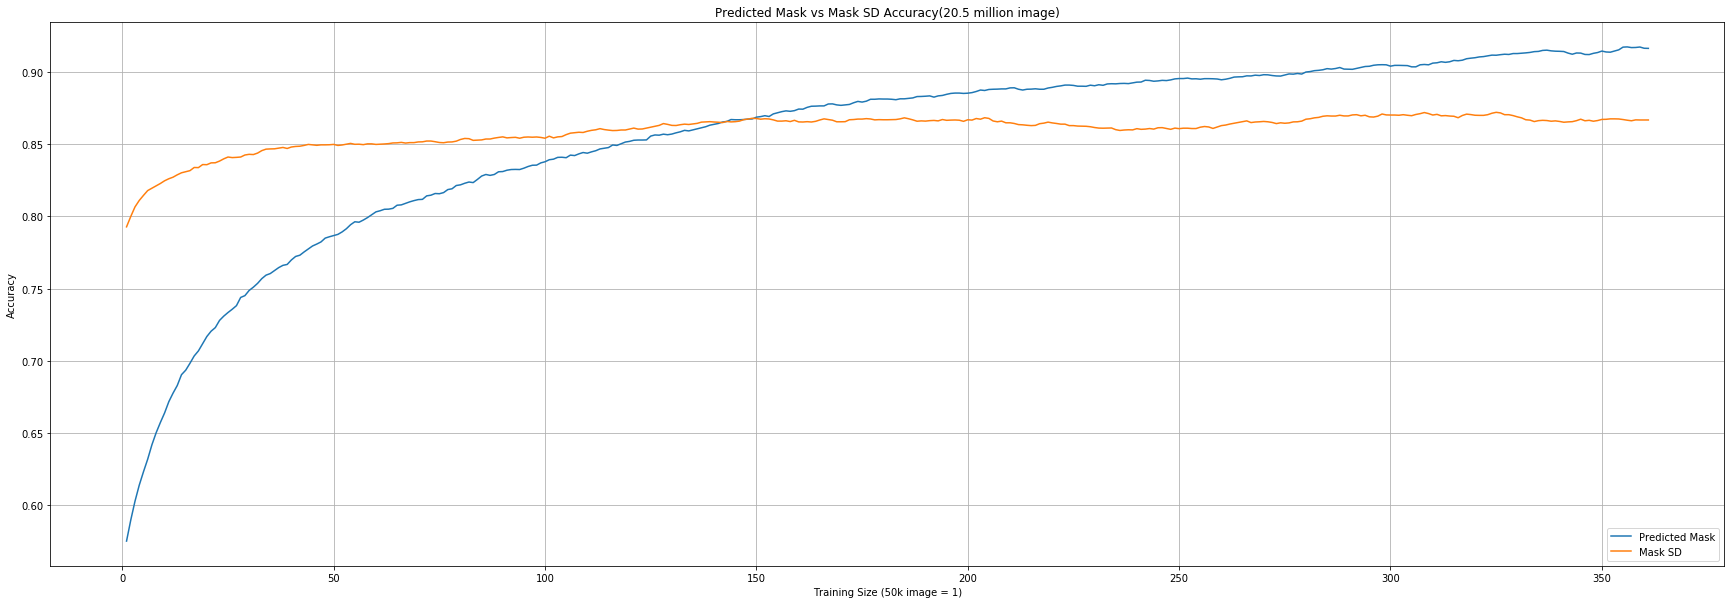

In [3]:
mask = np.array([0.00390625, 0.0703125, 0.12109375, 0.2890625, 0.3359375, 0.296875, 0.33203125, 0.390625, 0.41015625, 0.421875, 0.45703125, 0.515625, 0.42578125, 0.58203125, 0.53125, 0.546875, 0.578125, 0.54296875, 0.57421875, 0.609375, 0.62109375, 0.546875, 0.62890625, 0.66015625, 0.68359375, 0.62890625, 0.5390625, 0.6953125, 0.6640625, 0.671875, 0.69140625, 0.6796875, 0.64453125, 0.67578125, 0.69140625, 0.75, 0.71484375, 0.7265625, 0.6953125, 0.69921875, 0.765625, 0.71875, 0.71875, 0.71875, 0.73828125, 0.76171875, 0.72265625, 0.75, 0.75390625, 0.74609375, 0.734375, 0.72265625, 0.67578125, 0.75390625, 0.7734375, 0.796875, 0.75, 0.74609375, 0.7421875, 0.8125, 0.75390625, 0.78125, 0.80078125, 0.73828125, 0.76953125, 0.80078125, 0.75390625, 0.79296875, 0.82421875, 0.79296875, 0.74609375, 0.796875, 0.77734375, 0.78515625, 0.796875, 0.75390625, 0.82421875, 0.7578125, 0.84375, 0.78515625, 0.82421875, 0.84375, 0.765625, 0.73046875, 0.79296875, 0.85546875, 0.79296875, 0.7578125, 0.8515625, 0.8203125, 0.80859375, 0.83203125, 0.82421875, 0.8203125, 0.8046875, 0.8359375, 0.85546875, 0.796875, 0.79296875, 0.7890625, 0.8203125, 0.83203125, 0.81640625, 0.85546875, 0.7578125, 0.87109375, 0.8359375, 0.84375, 0.84375, 0.8515625, 0.8046875, 0.78515625, 0.828125, 0.84765625, 0.78125, 0.85546875, 0.8046875, 0.8359375, 0.859375, 0.80078125, 0.8671875, 0.8203125, 0.8359375, 0.77734375, 0.8359375, 0.859375, 0.8515625, 0.87109375, 0.8671875, 0.83984375, 0.8671875, 0.82421875, 0.875, 0.84765625, 0.84765625, 0.82421875, 0.82421875, 0.8515625, 0.859375, 0.8671875, 0.83203125, 0.8359375, 0.8203125, 0.8671875, 0.86328125, 0.87890625, 0.859375, 0.875, 0.83203125, 0.859375, 0.83984375, 0.89453125, 0.8203125, 0.83984375, 0.84765625, 0.85546875, 0.89453125, 0.890625, 0.8203125, 0.8984375, 0.84375, 0.84765625, 0.8515625, 0.87109375, 0.87109375, 0.83984375, 0.86328125, 0.89453125, 0.8828125, 0.83984375, 0.875, 0.8203125, 0.83984375, 0.91015625, 0.875, 0.8515625, 0.88671875, 0.8515625, 0.890625, 0.8828125, 0.90234375, 0.875, 0.85546875, 0.8828125, 0.87890625, 0.8671875, 0.859375, 0.90625, 0.890625, 0.89453125, 0.8828125, 0.85546875, 0.88671875, 0.859375, 0.86328125, 0.88671875, 0.875, 0.87890625, 0.89453125, 0.87890625, 0.87109375, 0.8671875, 0.91015625, 0.87890625, 0.88671875, 0.8828125, 0.87890625, 0.9140625, 0.875, 0.89453125, 0.90625, 0.88671875, 0.85546875, 0.87890625, 0.87109375, 0.90625, 0.8671875, 0.859375, 0.8671875, 0.85546875, 0.890625, 0.87890625, 0.88671875, 0.88671875, 0.90625, 0.91796875, 0.88671875, 0.86328125, 0.88671875, 0.8828125, 0.89453125, 0.859375, 0.88671875, 0.8828125, 0.89453125, 0.8828125, 0.90625, 0.91015625, 0.8984375, 0.90625, 0.83984375, 0.8984375, 0.90234375, 0.8984375, 0.89453125, 0.8984375, 0.875, 0.8671875, 0.90234375, 0.8984375, 0.91015625, 0.91796875, 0.89453125, 0.9140625, 0.89453125, 0.88671875, 0.88671875, 0.9140625, 0.91015625, 0.8984375, 0.85546875, 0.859375, 0.8828125, 0.8828125, 0.8828125, 0.890625, 0.8671875, 0.90234375, 0.890625, 0.88671875, 0.91015625, 0.90625, 0.88671875, 0.875, 0.87890625, 0.91796875, 0.8828125, 0.90234375, 0.8671875, 0.91796875, 0.875, 0.90625, 0.89453125, 0.87890625, 0.90625, 0.88671875, 0.8984375, 0.9375, 0.921875, 0.91015625, 0.90234375, 0.890625, 0.875, 0.91015625, 0.9140625, 0.890625, 0.8984375, 0.90234375, 0.9140625, 0.8984375, 0.92578125, 0.890625, 0.8984375, 0.8984375, 0.9140625, 0.88671875, 0.8828125, 0.90625, 0.8828125, 0.91796875, 0.88671875, 0.90234375, 0.890625, 0.88671875, 0.9140625, 0.88671875, 0.89453125, 0.890625, 0.91796875, 0.8828125, 0.88671875, 0.890625, 0.8828125, 0.91015625, 0.91796875, 0.91015625, 0.90625, 0.8828125, 0.9375, 0.93359375, 0.90625, 0.91796875, 0.9140625, 0.91796875, 0.890625, 0.90625, 0.93359375, 0.8828125, 0.91796875, 0.90625, 0.93359375, 0.921875, 0.91015625, 0.91796875, 0.94921875, 0.90625, 0.90234375, 0.8984375, 0.8671875, 0.92578125, 0.92578125, 0.88671875, 0.89453125, 0.85546875, 0.9140625, 0.95703125, 0.89453125, 0.89453125, 0.94140625, 0.9296875, .921875, 0.8828125, 0.91015625, 0.93359375, 0.90234375, 0.90625, 0.9453125, 0.91015625, 0.93359375, 0.91015625, 0.8984375, 0.91796875, 0.90625, 0.90625, 0.9375, 0.92578125, 0.8984375, 0.9140625, 0.9375, 0.9453125, 0.91796875, 0.93359375, 0.94140625, 0.92578125, 0.92578125, 0.9140625, 0.91015625, 0.87109375, 0.9140625, 0.8984375, 0.87890625, 0.8828125, 0.953125, 0.9140625, 0.90234375, 0.90234375, 0.9453125, 0.92578125, 0.91796875, 0.89453125, 0.91796875, 0.9296875, 0.93359375, 0.94921875, 0.921875, 0.93359375, 0.8984375, 0.91015625, 0.8984375, 0.92578125])
mask_sd = np.array([0.4921875, 0.5078125, 0.609375, 0.69140625, 0.6875, 0.78125, 0.74609375, 0.7734375, 0.78515625, 0.76171875, 0.79296875, 0.75390625, 0.78515625, 0.8046875, 0.79296875, 0.765625, 0.8125, 0.76953125, 0.82421875, 0.78515625, 0.828125, 0.8046875, 0.78125, 0.8203125, 0.85546875, 0.828125, 0.8125, 0.78515625, 0.8203125, 0.8515625, 0.8046875, 0.81640625, 0.80078125, 0.8125, 0.83984375, 0.83203125, 0.83203125, 0.87109375, 0.796875, 0.8828125, 0.84765625, 0.81640625, 0.83984375, 0.83984375, 0.8671875, 0.81640625, 0.8515625, 0.87109375, 0.84765625, 0.84375, 0.8515625, 0.83984375, 0.83203125, 0.8671875, 0.85546875, 0.86328125, 0.828125, 0.85546875, 0.87890625, 0.83203125, 0.84765625, 0.8359375, 0.85546875, 0.83984375, 0.83203125, 0.875, 0.80859375, 0.875, 0.8203125, 0.84765625, 0.83203125, 0.86328125, 0.859375, 0.8828125, 0.8359375, 0.8359375, 0.82421875, 0.85546875, 0.84375, 0.84375, 0.85546875, 0.90234375, 0.8515625, 0.8203125, 0.84375, 0.85546875, 0.85546875, 0.8359375, 0.84765625, 0.90234375, 0.85546875, 0.84375, 0.875, 0.82421875, 0.8515625, 0.83203125, 0.8515625, 0.875, 0.859375, 0.80859375, 0.8671875, 0.8671875, 0.859375, 0.8359375, 0.859375, 0.84765625, 0.85546875, 0.85546875, 0.859375, 0.83984375, 0.85546875, 0.84765625, 0.87890625, 0.84375, 0.84765625, 0.8515625, 0.82421875, 0.875, 0.84375, 0.8515625, 0.859375, 0.86328125, 0.8359375, 0.85546875, 0.828125, 0.859375, 0.828125, 0.8828125, 0.90234375, 0.87890625, 0.84765625, 0.84375, 0.859375, 0.828125, 0.875, 0.85546875, 0.88671875, 0.859375, 0.8671875, 0.8671875, 0.8671875, 0.8515625, 0.84375, 0.859375, 0.859375, 0.82421875, 0.859375, 0.859375, 0.83203125, 0.87890625, 0.80859375, 0.90234375, 0.87109375, 0.90234375, 0.91015625, 0.86328125, 0.87109375, 0.84765625, 0.90234375, 0.87109375, 0.875, 0.88671875, 0.84765625, 0.82421875, 0.83203125, 0.85546875, 0.83984375, 0.875, 0.87890625, 0.8828125, 0.82421875, 0.8671875, 0.8671875, 0.8828125, 0.8671875, 0.88671875, 0.890625, 0.85546875, 0.8671875, 0.875, 0.875, 0.86328125, 0.84765625, 0.84765625, 0.89453125, 0.8984375, 0.89453125, 0.8671875, 0.85546875, 0.859375, 0.85546875, 0.890625, 0.828125, 0.8671875, 0.87890625, 0.875, 0.87890625, 0.88671875, 0.82421875, 0.85546875, 0.82421875, 0.89453125, 0.83984375, 0.859375, 0.91015625, 0.875, 0.84375, 0.890625, 0.84765625, 0.8671875, 0.88671875, 0.875, 0.87109375, 0.87109375, 0.87109375, 0.83203125, 0.81640625, 0.8203125, 0.87890625, 0.88671875, 0.890625, 0.875, 0.8828125, 0.8828125, 0.8828125, 0.875, 0.859375, 0.86328125, 0.86328125, 0.875, 0.87890625, 0.8671875, 0.87109375, 0.8828125, 0.86328125, 0.859375, 0.84765625, 0.87890625, 0.84765625, 0.875, 0.86328125, 0.875, 0.875, 0.83984375, 0.88671875, 0.87890625, 0.87109375, 0.84765625, 0.87890625, 0.84375, 0.87890625, 0.87109375, 0.890625, 0.8359375, 0.8203125, 0.84765625, 0.8671875, 0.83203125, 0.84765625, 0.84375, 0.84765625, 0.8671875, 0.85546875, 0.859375, 0.87890625, 0.890625, 0.8359375, 0.85546875, 0.8515625, 0.8671875, 0.8671875, 0.875, 0.83203125, 0.8828125, 0.8671875, 0.87109375, 0.85546875, 0.84765625, 0.8359375, 0.85546875, 0.875, 0.87109375, 0.875, 0.82421875, 0.8359375, 0.875, 0.85546875, 0.875, 0.890625, 0.8515625, 0.87109375, 0.89453125, 0.85546875, 0.88671875, 0.890625, 0.8515625, 0.83984375, 0.890625, 0.859375, 0.859375, 0.87890625, 0.859375, 0.890625, 0.8828125, 0.84375, 0.83203125, 0.81640625, 0.87890625, 0.8984375, 0.86328125, 0.8828125, 0.89453125, 0.88671875, 0.87890625, 0.91015625, 0.83203125, 0.85546875, 0.86328125, 0.86328125, 0.85546875, 0.84375, 0.8359375, 0.859375, 0.8671875, 0.87890625, 0.90625, 0.859375, 0.87109375, 0.90234375, 0.87109375, 0.90625, 0.88671875, 0.9140625, 0.83984375, 0.828125, 0.875, 0.8828125, 0.8515625, 0.890625, 0.88671875, 0.87890625, 0.85546875, 0.875, 0.83203125, 0.8828125, 0.8828125, 0.9140625, 0.859375, 0.85546875, 0.859375, 0.87109375, 0.87890625, 0.87109375, 0.8671875, 0.88671875, 0.859375, 0.85546875, 0.84375, 0.84765625, 0.88671875, 0.83203125, 0.90234375, 0.87109375, 0.87109375, 0.859375, 0.91015625, 0.90234375, 0.84765625, 0.83984375, 0.8515625, 0.84375, 0.859375, 0.91015625, 0.8984375, 0.859375, 0.84375, 0.859375, 0.83984375, 0.859375, 0.8359375, 0.83984375, 0.875, 0.86328125, 0.87109375, 0.83984375, 0.8671875, 0.859375, 0.86328125, 0.87109375, 0.859375, 0.890625, 0.86328125, 0.91015625, 0.8828125, 0.828125, 0.8984375, 0.8828125, 0.8828125, 0.89453125, 0.86328125, 0.88671875, 0.87890625, 0.8671875, 0.84765625, 0.86328125, 0.83984375, 0.88671875, 0.83984375, 0.84765625, 0.88671875])
sd = np.array([0.48828125, 0.51171875, 0.5078125, 0.4765625, 0.421875, 0.45703125, 0.54296875, 0.51171875, 0.5390625, 0.515625, 0.47265625, 0.42578125, 0.4453125, 0.51171875, 0.39453125, 0.5, 0.453125, 0.47265625, 0.45703125, 0.56640625, 0.53125, 0.51171875, 0.49609375, 0.44921875, 0.43359375, 0.5078125, 0.453125, 0.48046875, 0.53125, 0.51953125, 0.46484375, 0.5, 0.46484375, 0.5546875, 0.61328125, 0.6875, 0.7265625, 0.66796875, 0.75390625, 0.68359375, 0.734375, 0.66796875, 0.74609375, 0.7421875, 0.7890625, 0.76171875, 0.77734375, 0.796875, 0.7578125, 0.75, 0.7890625, 0.75390625, 0.75, 0.7421875, 0.83984375, 0.75390625, 0.8203125, 0.78515625, 0.8125, 0.80859375, 0.78515625, 0.78515625, 0.8125, 0.7734375, 0.828125, 0.796875, 0.86328125, 0.8046875, 0.84765625, 0.80859375, 0.828125, 0.828125, 0.79296875, 0.828125, 0.796875, 0.81640625, 0.83203125, 0.82421875, 0.83203125, 0.84375, 0.796875, 0.85546875, 0.828125, 0.79296875, 0.80078125, 0.83984375, 0.81640625, 0.8203125, 0.83984375, 0.83203125, 0.84375, 0.85546875, 0.8203125, 0.82421875, 0.78515625, 0.828125, 0.828125, 0.8203125, 0.80078125, 0.8359375, 0.8359375, 0.8046875, 0.82421875, 0.80078125, 0.84765625, 0.84765625, 0.83203125, 0.81640625, 0.82421875, 0.77734375, 0.84765625, 0.84375, 0.8359375, 0.8359375, 0.83984375, 0.8203125, 0.86328125, 0.83203125, 0.8515625, 0.85546875, 0.81640625, 0.83984375, 0.82421875, 0.828125, 0.828125, 0.8359375, 0.86328125, 0.85546875, 0.8359375, 0.8515625, 0.8515625, 0.8046875, 0.83203125, 0.859375, 0.8515625, 0.86328125, 0.84375, 0.81640625, 0.82421875, 0.859375, 0.8359375, 0.87109375, 0.83984375, 0.82421875, 0.87890625, 0.83984375, 0.84375, 0.86328125, 0.8671875, 0.88671875, 0.83984375, 0.8046875, 0.859375, 0.88671875, 0.8125, 0.84765625, 0.84375, 0.8515625, 0.83984375, 0.84765625, 0.796875, 0.82421875, 0.82421875, 0.890625, 0.87890625, 0.82421875, 0.87109375, 0.85546875, 0.84765625, 0.828125, 0.8671875, 0.84375, 0.87890625, 0.8828125, 0.875, 0.8125, 0.875, 0.82421875, 0.8359375, 0.8046875, 0.875, 0.859375, 0.828125, 0.84765625, 0.859375, 0.84765625, 0.87890625, 0.85546875, 0.8828125, 0.8359375, 0.828125, 0.8046875, 0.84375, 0.83984375, 0.859375, 0.796875, 0.84765625, 0.8671875, 0.85546875, 0.87890625, 0.85546875, 0.81640625, 0.82421875, 0.86328125, 0.84765625, 0.8515625, 0.83984375, 0.8671875, 0.8515625, 0.83203125, 0.83984375, 0.8828125, 0.83203125, 0.81640625, 0.8671875, 0.8515625, 0.8984375, 0.828125, 0.87109375, 0.8515625, 0.8203125, 0.87109375, 0.85546875, 0.875, 0.8359375, 0.79296875, 0.84375, 0.84765625, 0.8515625, 0.8203125, 0.87890625, 0.84375, 0.8359375, 0.81640625, 0.85546875, 0.8359375, 0.8671875, 0.8203125, 0.84765625, 0.84765625, 0.85546875, 0.875, 0.8125, 0.89453125, 0.84375, 0.8359375, 0.84375, 0.859375, 0.83984375, 0.88671875, 0.8828125, 0.83203125, 0.8671875, 0.84765625, 0.875, 0.84765625, 0.86328125, 0.8984375, 0.86328125, 0.859375, 0.8828125, 0.84765625, 0.8203125, 0.83984375, 0.859375, 0.81640625, 0.88671875, 0.87890625, 0.86328125, 0.8046875, 0.8515625, 0.8828125, 0.8984375, 0.84765625, 0.82421875, 0.86328125, 0.828125, 0.87890625, 0.82421875, 0.8046875, 0.8828125, 0.87890625, 0.87109375, 0.8359375, 0.83984375, 0.87890625, 0.8828125, 0.86328125, 0.86328125, 0.90625, 0.8671875, 0.88671875, 0.83203125, 0.84765625, 0.83984375, 0.83203125, 0.875, 0.875, 0.88671875, 0.8125, 0.84375, 0.875, 0.8203125, 0.86328125, 0.86328125, 0.8515625, 0.83203125, 0.84375, 0.828125, 0.86328125, 0.8984375, 0.8515625, 0.87890625, 0.8203125, 0.87109375, 0.859375, 0.85546875, 0.90625, 0.87890625, 0.87890625, 0.8515625, 0.796875, 0.88671875, 0.8515625, 0.8046875, 0.87109375, 0.8671875, 0.85546875, 0.828125, 0.890625, 0.83984375, 0.8671875, 0.8671875, 0.875, 0.84375, 0.87109375, 0.90234375, 0.88671875, 0.83984375, 0.87109375, 0.87890625, 0.84375, 0.8515625, 0.8046875, 0.89453125, 0.828125, 0.8671875, 0.84765625, 0.859375, 0.84765625, 0.89453125, 0.875, 0.8671875, 0.8515625, 0.8359375, 0.859375, 0.88671875, 0.84375, 0.8671875, 0.83984375, 0.8125, 0.8515625, 0.8515625, 0.87109375, 0.87109375, 0.8125, 0.88671875, 0.83203125, 0.87109375, 0.87890625, 0.83203125, 0.87890625, 0.87109375, 0.87109375, 0.84375, 0.84375, 0.89453125, 0.89453125, 0.84765625, 0.87109375, 0.85546875, 0.890625, 0.83984375, 0.890625, 0.84375, 0.8515625, 0.890625, 0.8828125, 0.8203125, 0.8828125, 0.80859375, 0.87109375, 0.86328125, 0.87109375, 0.8515625, 0.8203125, 0.859375, 0.86328125, 0.8359375, 0.85546875, 0.86328125, 0.88671875, 0.8671875, 0.91796875, 0.86328125, 0.8671875, 0.859375, 0.84375, 0.828125, 0.828125])
sr = np.array([0.84375, 0.84765625, 0.85546875, 0.84765625, 0.8515625, 0.84375, 0.86328125, 0.80078125, 0.85546875, 0.8515625, 0.85546875, 0.8203125, 0.875, 0.8515625, 0.8515625, 0.87109375, 0.84375, 0.84765625, 0.84375, 0.85546875, 0.87890625, 0.83203125, 0.87109375, 0.87890625, 0.8515625, 0.8359375, 0.828125, 0.81640625, 0.87109375, 0.84765625, 0.875, 0.859375, 0.84375, 0.8203125, 0.87890625, 0.859375, 0.84765625, 0.89453125, 0.86328125, 0.85546875, 0.83984375, 0.8515625, 0.87109375, 0.85546875, 0.89453125, 0.859375, 0.890625, 0.8515625, 0.86328125, 0.83984375, 0.84765625, 0.828125, 0.875, 0.8828125, 0.8359375, 0.83203125, 0.84375, 0.859375, 0.8359375, 0.859375, 0.88671875, 0.83203125, 0.8671875, 0.85546875, 0.8359375, 0.875, 0.8515625, 0.8359375, 0.87890625, 0.87109375, 0.8828125, 0.8359375, 0.87890625, 0.8515625, 0.90234375, 0.87109375, 0.89453125, 0.84375, 0.83984375, 0.8515625, 0.87109375, 0.89453125, 0.8671875, 0.86328125, 0.8828125, 0.859375, 0.87890625, 0.890625, 0.875, 0.86328125, 0.81640625, 0.875, 0.859375, 0.85546875, 0.859375, 0.84765625, 0.8515625, 0.84765625, 0.85546875, 0.84375, 0.859375, 0.859375, 0.87890625, 0.82421875, 0.828125, 0.84375, 0.89453125, 0.83984375, 0.84375, 0.82421875, 0.83203125, 0.86328125, 0.828125, 0.8359375, 0.88671875, 0.85546875, 0.87890625, 0.8515625, 0.88671875, 0.85546875, 0.89453125, 0.87890625, 0.84765625, 0.87109375, 0.83203125, 0.8828125, 0.85546875, 0.875, 0.8828125, 0.87109375, 0.8515625, 0.8984375, 0.83984375, 0.89453125, 0.86328125, 0.87109375, 0.83984375, 0.8828125, 0.89453125, 0.8515625, 0.859375, 0.828125, 0.91796875, 0.87890625, 0.83203125, 0.828125, 0.84765625, 0.8671875, 0.88671875, 0.86328125, 0.83984375, 0.85546875, 0.890625, 0.8125, 0.83984375, 0.86328125, 0.8828125, 0.87890625, 0.84765625, 0.87109375, 0.8671875, 0.85546875, 0.875, 0.890625, 0.87890625, 0.85546875, 0.87890625, 0.85546875, 0.86328125, 0.8984375, 0.89453125, 0.82421875, 0.89453125, 0.9140625, 0.87890625, 0.8359375, 0.890625, 0.85546875, 0.875, 0.84765625, 0.8671875, 0.87109375, 0.8828125, 0.875, 0.890625, 0.87109375, 0.90234375, 0.90625, 0.83984375, 0.890625, 0.82421875, 0.84375, 0.89453125, 0.890625, 0.86328125, 0.90625, 0.84765625, 0.86328125, 0.85546875, 0.875, 0.90234375, 0.87109375, 0.84765625, 0.85546875, 0.8828125, 0.85546875, 0.84765625, 0.89453125, 0.859375, 0.88671875, 0.87890625, 0.86328125, 0.8671875, 0.8046875, 0.84375, 0.87890625, 0.890625, 0.8359375, 0.8671875, 0.89453125, 0.8515625, 0.8984375, 0.87109375, 0.87109375, 0.89453125, 0.859375, 0.91796875, 0.87890625, 0.87890625, 0.91015625, 0.84765625, 0.84765625, 0.89453125, 0.85546875, 0.87890625, 0.8828125, 0.84375, 0.9296875, 0.8671875, 0.8671875, 0.87109375, 0.85546875, 0.85546875, 0.8359375, 0.84765625, 0.828125, 0.8359375, 0.890625, 0.828125, 0.8671875, 0.91015625, 0.87109375, 0.890625, 0.89453125, 0.87890625, 0.8984375, 0.83203125, 0.90625, 0.88671875, 0.859375, 0.83203125, 0.84765625, 0.87109375, 0.890625, 0.8828125, 0.875, 0.859375, 0.91015625, 0.8828125, 0.88671875, 0.8125, 0.875, 0.875, 0.828125, 0.890625, 0.84765625, 0.85546875, 0.859375, 0.87109375, 0.86328125, 0.859375, 0.875, 0.859375, 0.90234375, 0.87109375, 0.890625, 0.84375, 0.890625, 0.87890625, 0.86328125, 0.8671875, 0.87109375, 0.875, 0.84765625, 0.84375, 0.90234375, 0.859375, 0.828125, 0.8984375, 0.859375, 0.87109375, 0.859375, 0.90625, 0.8984375, 0.8125, 0.87890625, 0.875, 0.88671875, 0.83203125, 0.8671875, 0.87890625, 0.890625, 0.86328125, 0.859375, 0.91796875, 0.87890625, 0.90234375, 0.87890625, 0.86328125, 0.875, 0.859375, 0.83984375, 0.859375, 0.8671875, 0.87890625, 0.8984375, 0.890625, 0.875, 0.88671875, 0.87890625, 0.87890625, 0.875, 0.8671875, 0.890625, 0.90625, 0.8671875, 0.8984375, 0.83984375, 0.86328125, 0.859375, 0.8828125, 0.8828125, 0.86328125, 0.8359375, 0.87109375, 0.9140625, 0.91015625, 0.8984375, 0.859375, 0.86328125, 0.86328125, 0.88671875, 0.8828125, 0.84765625, 0.89453125, 0.875, 0.87109375, 0.875, 0.875, 0.8515625, 0.87109375, 0.84765625, 0.83984375, 0.8671875, 0.875, 0.8203125, 0.8671875, 0.84375, 0.875, 0.890625, 0.87890625, 0.86328125, 0.89453125, 0.890625, 0.87890625, 0.85546875, 0.859375, 0.875, 0.859375, 0.86328125, 0.890625, 0.85546875, 0.87890625, 0.87890625, 0.859375, 0.84375, 0.8984375, 0.88671875, 0.87109375, 0.89453125, 0.875, 0.84765625, 0.8515625, 0.890625, 0.8671875, 0.84765625, 0.8984375, 0.8515625, 0.859375, 0.8828125, 0.875, 0.875, 0.87890625, 0.8671875, 0.875, 0.87109375, 0.86328125, 0.87109375, 0.8671875, 0.90625])
N = 50

mask = np.convolve(mask, np.ones((N,))/N, mode='valid')
mask_sd = np.convolve(mask_sd, np.ones((N,))/N, mode='valid')
sd = np.convolve(sd, np.ones((N,))/N, mode='valid')
sr = np.convolve(sr, np.ones((N,))/N, mode='valid')


train_size = np.arange(1, len(mask_sd) + 1)

# plt.figure(1,figsize=(30,20))
# plt.subplot(1, 2, 1)
# plt.plot(train_size[:100],mask_sd[:100])
# plt.plot(train_size[:100], sd[:100])
# plt.plot(train_size[:100],sr[:100])
# plt.xlabel('Training Size (50k image = 1)')
# plt.ylabel("Accuracy")
# plt.title("SD vs SR vs Mask(first 5 million images)")
# plt.grid(True)
# plt.legend(['Mask-based Network', 'SD', 'SR'], loc="lower right")
# plt.style.use(['classic'])

# plt.subplot(1, 2, 2)
# plt.plot(train_size[100:410],mask_sd[100:410])
# plt.plot(train_size[100:410], sd[100:410])
# plt.plot(train_size[100:410],sr[100:410])
# plt.xlabel('Training Size (50k image = 1)')
# plt.ylabel("Accuracy")
# plt.title("SD vs SR vs Mask(next 15.5 million images)")
# plt.grid(True)
# plt.legend(['Mask-based Network', 'SD', 'SR'], loc="lower right")
# plt.style.use(['classic'])


# plt.show()


plt.figure(2,figsize=(30,10))
# plt.subplot(1, 2, 1)
plt.plot(train_size,mask)
plt.plot(train_size,mask_sd)

plt.xlabel('Training Size (50k image = 1)')
plt.ylabel("Accuracy")
plt.title("Predicted Mask vs Mask SD Accuracy(20.5 million image)")
plt.grid(True)
plt.legend(['Predicted Mask', 'Mask SD'], loc="lower right")
plt.style.use(['classic'])

plt.show()